# Operating Systems Report - 231006

### Setting Up the Experiments
All of the experiments can be run using the `run.sh` bash script.

```bash
bash run.sh > run.log
```

 This creates a new directory for each experiment named `experiment<number>`, this directory contains three subdirectories:
* `inputs` - contains the input data (`input_data_<seed>`) and parameters (`input_params_<seed>`) for the experiment
* `schedulers` - contains the output files from the experiment from each scheduler under `scheduler/<scheduler>`
* `sim_params` - contains the output files from the experiment from each scheduler under `sim_params/<scheduler>_sim_params.prp`

In the following experiments, I make use of the `Experiment` class I created, defined in `experiment.py`.

# Experiment 1 - Comparing the average wait time for each algorithm

## Introduction
In this experiment, I look to find out which scheduling algorithm is best used when it comes to minimizing the average waiting time. I hypothesise that the best scheduling algorithm for minimising wait time is the Multilevel Feed Back Queue with Round Robin, which, is the pre-emptive and when using a time quantum, is able to context switch from longer processes when they exceed the time quantum. I expect that shortest job first with exponential averaging will perform poorly compared to the other scheduling algorithms owing to the fact that it is non-preemptive.

## Methodology
In order to test which algorithm has the best average waiting time, I will run the experiment (and all subsequent experiments) using the `run.sh` script. This will run the experiment for each scheduling, for each scheduling algorithm, we will choose 5 different seeds so that we can get a stable average waiting time. Inputs generated by the bash script are stored in `/experiment1/inputs` and the simulator parameters used are stored in `/experiment1/sim_params/`. Outputs are stored in `/experiment1/schedulers/[scheduler]` The only variation in the parameters is the scheduling algorithm used. I will calculate the average waiting time across all 5 seeds for each scheduling algorithm and then compare the average waiting times for each scheduling algorithm, this way I can see which algorithm has the best average waiting time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from experiment import Experiment

exp = Experiment('../experiment1')

print(f"Seeds Used for Experiment 1: {exp.all_seeds()} ")

exp.input_params[1][1]

Seeds Used for Experiment 1: ['100', '50', '200', '531', '120'] 


,value
param,
numberOfProcesses,50
staticPriority,0
meanInterArrival,12
meanCpuBurst,10
meanIoBurst,10
meanNumberBursts,6
seed,50


In [2]:
print("Simulation params of experiment: (note scheduler is missing as it will be changing)")
exp.sim_params[0].drop(['scheduler'])

Simulation params of experiment: (note scheduler is missing as it will be changing)


,value
param,
timeLimit,10000
interruptTime,1
timeQuantum,5
initialBurstEstimate,5
alphaBurstEstimate,0.5
periodic,false


As can be seen above, we use an interrupt time of `1 unit` and a time quantum of `5 units`. I chose these values so ensure that the processes that use RoundRobin (RR) and Feedback Round Robin (FRR) are forced to make a context switch so that they cannot always run for the entire time quantum. I chose the ratio 1:5 to reduce too much overhead in the system to try and get a fair comparison.

## Results


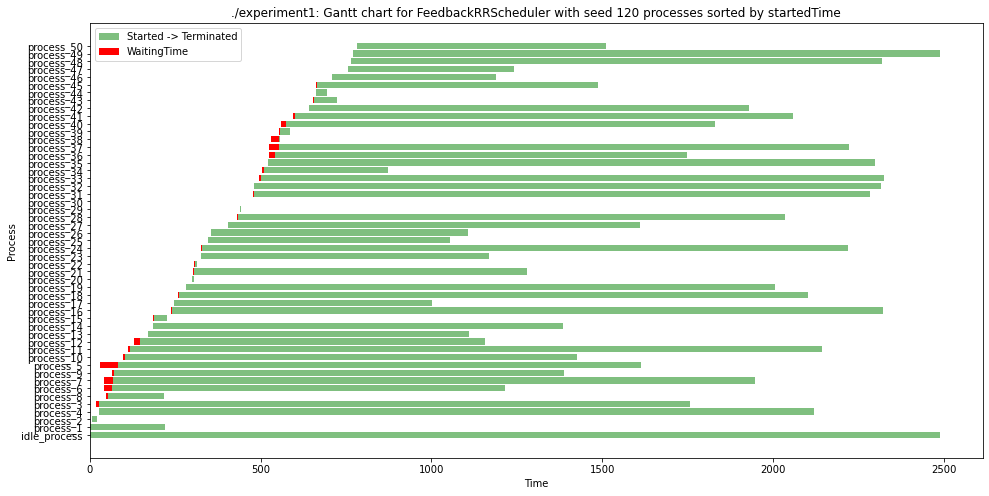

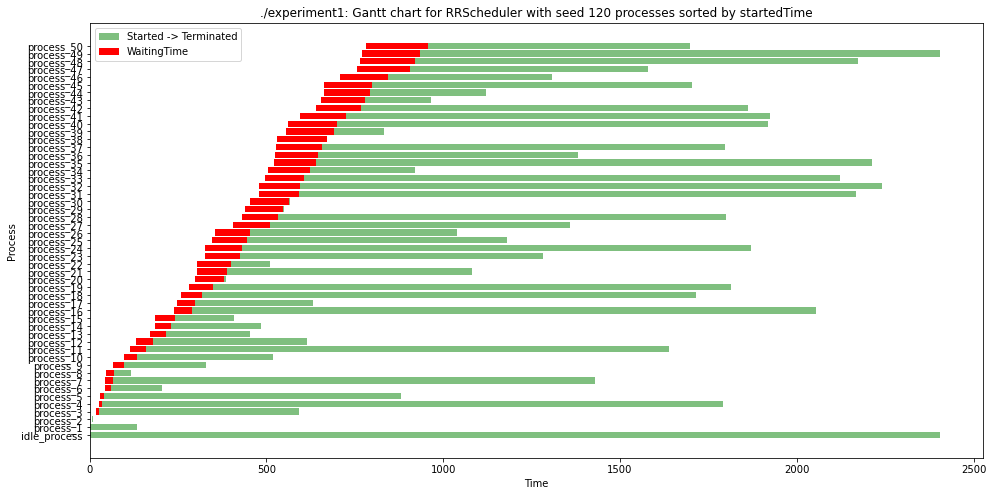

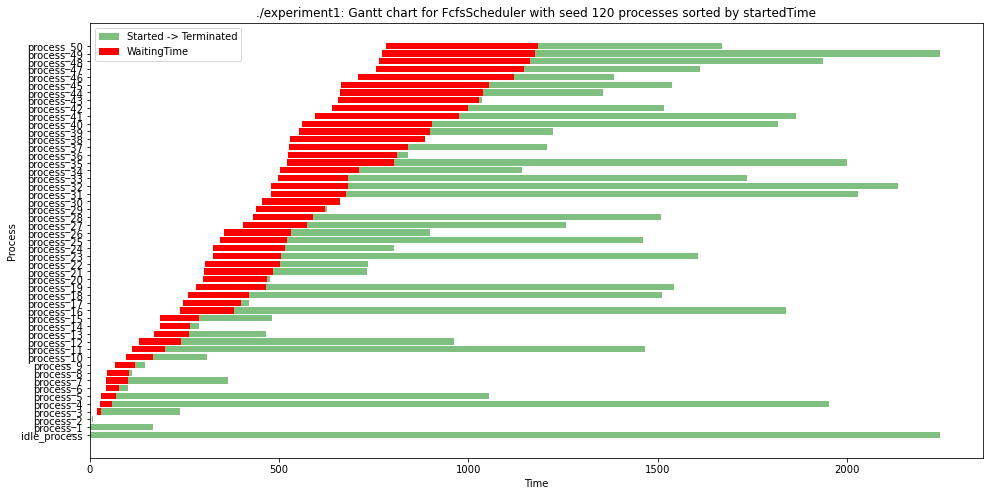

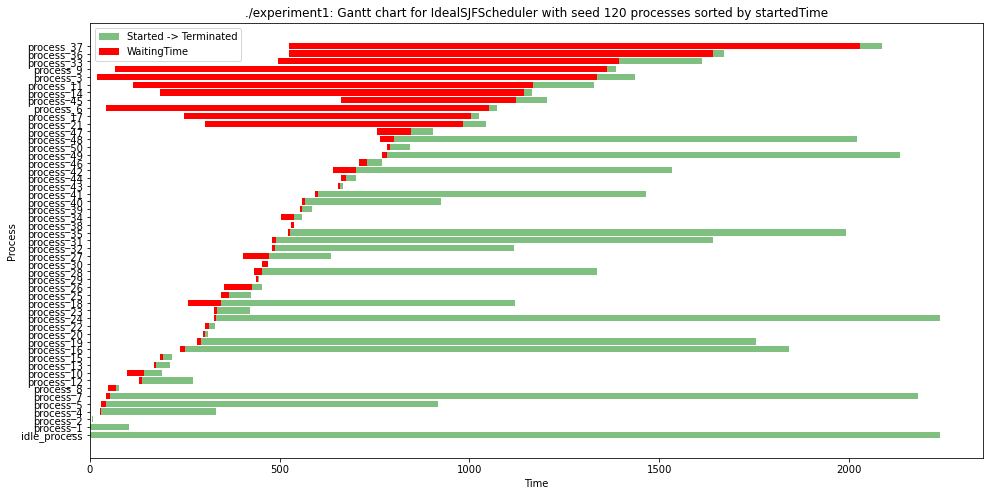

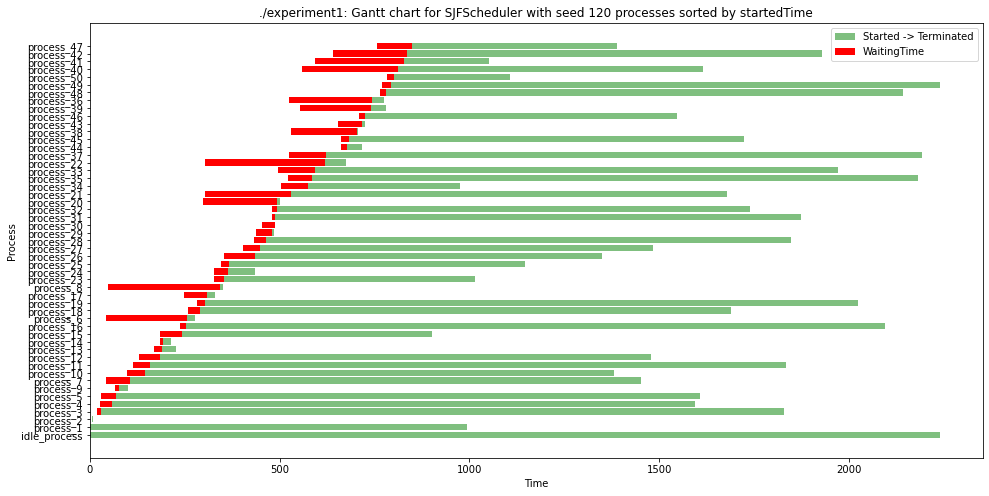

In [3]:
## Plotting and Comparing Gantt Charts for Different Schedulers 
exp.plot_gantt('FeedbackRRScheduler', '120')
exp.plot_gantt('RRScheduler', '120')
exp.plot_gantt('FcfsScheduler', '120')
exp.plot_gantt('IdealSJFScheduler', '120')
exp.plot_gantt('SJFScheduler', '120')

As can clearly be seen from the above example, the wait time on the Feedback Round Robin (FRR) algorithm is the lowest, followed by the Round Robin Algorithm algorithm. To validate this result, I will look across multiple different seeds and analyse the average waiting time for each scheduling algorithm.

In [4]:
meanWaitingTimes = exp.get_output_col('waitingTime').mean()
meanWaitingTimes

newCols = set(meanWaitingTimes.index.map(lambda x: x.split('_')[0]))
stats = pd.DataFrame(index=newCols, columns=["MeanWaitingTime"])

# Calculating the means for each scheduler
for scheduler in newCols:
	matching = [col for col in meanWaitingTimes.index if scheduler in col]
	meanOfScheduler = meanWaitingTimes[matching].mean()

	stats['MeanWaitingTime'][scheduler] = meanOfScheduler
stats


,MeanWaitingTime
SJFScheduler,228.266667
RRScheduler,60.166667
FeedbackRRScheduler,17.062745
IdealSJFScheduler,281.54902
FcfsScheduler,244.913725


Text(0, 0.5, 'Scheduler')

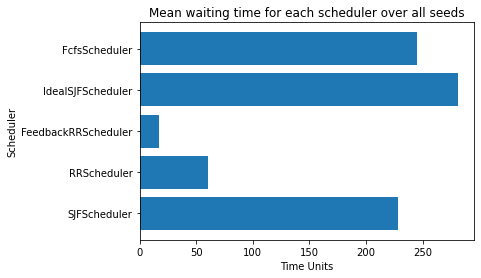

In [5]:
plt.barh(stats.index, stats['MeanWaitingTime'])
plt.title("Mean waiting time for each scheduler over all seeds")

plt.xlabel("Time Units")
plt.ylabel("Scheduler")

As can be seen above, the `FeedbackRRScheduler` algorithm which uses round robin and a multi-level queue that demotes the process and returns it to the back of the queue when it has reached its time quantum has the best average waiting time when given the same input as the other algorithms, this is followed by the Round Robin algorithm. This shows a multi-level feedback queue with the Round Robin algorithm as the best algorithm for minimising average waiting time.

It is important to note that we must take into account the fact that the time quantum and small interrupt time is key to ensuring that a multi-level feedback queue with this approach outperforms the Ideal Shortest Job First algorithm. In cases where the time quantum is higher than the interrupt time, the multi-level feedback queue will outperform or match the Ideal Shortest Job First algorithm.

I am interested by the impact of the time quantum and interrupt time on the average waiting time for each scheduling algorithm and how the keen to look into how performance of Ideal Shortest Job First and the multi-level feedback queue compare.

It can also be noted that the waiting time for both the First Come First Serve is extremely long compared to other algorithms, this is likely down to the emerging of the convoy effect, where smaller processes are forced to wait for larger processes to finish. In addition, the Shortest Job First Algorithm is performing poorly likely as a result of starvation, since longer bursts are run last, these bursts may effect the waiting time if they arrive at similar times to many smaller processes, this effect can be seen in the Gantt charts above.

# Experiment 2 - Which scheduling algorithm is most effective for maximizing CPU utilization whilst minimizing average turnaround time?

## Introduction

I am interested it finding out what scheduling algorithm is most effective for maximizing CPU utilization whilst minimizing average turnaround time. 

In [6]:
exp = Experiment('../experiment2')
print(f"Seeds Used for Experiment 2: {exp.all_seeds()} ")

Seeds Used for Experiment 2: ['1234', '5678', '91011', '151617', '121314'] 


## Methodology
To analyse how different algorithms perform, I use the following parameters:

#### Input Parameters
```
numProcesses=25
interArrivalTime=10
meanIoBurstTime=24
meanCpuBurstTime=4
meanNumBursts=10
```

The mean IO burst time I have chosen to be substantially higher than the mean CPU burst time, this is to ensure that the workload is high and varied so that the convoy effect is more likely to occur. 

#### Simulator Parameters
```
timeLimit=5000
interruptTime=10
timeQuantum=4
initialBurstEstimate=14
alphaBurstEstimate=0.5
periodic=false
```

I have initially chosen these values to try and give the exponential averaging algorithm a good chance initially, will an initial burst time of `14` and an alpha burst time of `0.5`.

## Results

In [7]:
shortest_job_first_output = [o[1] for o in exp.get_output('SJFScheduler')]

print("Example of shortest job first output:")
shortest_job_first_output[3]

Example of shortest job first output:


,id,priority,createdTime,startedTime,terminatedTime,cpuTime,blockedTime,turnaroundTime,waitingTime,responseTime
process_1,1,0,0,10,221,105,2,221,12,10
process_2,2,0,9,31,440,183,6,431,28,22
process_25,25,0,389,476,498,22,0,109,87,87
process_7,7,0,80,253,515,62,10,435,183,173
process_6,6,0,74,463,581,12,2,507,391,389
process_10,10,0,145,673,986,106,6,841,534,528
process_24,24,0,359,591,1098,90,12,739,244,232
process_21,21,0,334,612,1175,115,14,841,292,278
process_20,20,0,326,1212,1277,33,1,951,887,886
process_19,19,0,313,1131,1391,40,5,1078,823,818


I will first examine the Gantt Charts for each scheduling algorithm with these parameters. To calculate CPU utilization, I intend to use the following formula (as defined in `experiment.py`):

```
CPU utilization = 100 - ((total_cpuTime - total_idleTime) / total_time)
```

In [8]:
def new_results():
	return pd.DataFrame(columns=["Seed", "Scheduler", "MeanWaitingTime", "MeanTurnaroundTime","MeanResponseTime", "CpuUtilization"])
	
results = new_results()

### Results for Seed 151617

CPU Utilization for FeedbackRRScheduler: 98.99%
CPU Utilization for RRScheduler: 98.988%
CPU Utilization for FcfsScheduler: 98.989%
CPU Utilization for IdealSJFScheduler: 98.985%
CPU Utilization for SJFScheduler: 98.997%


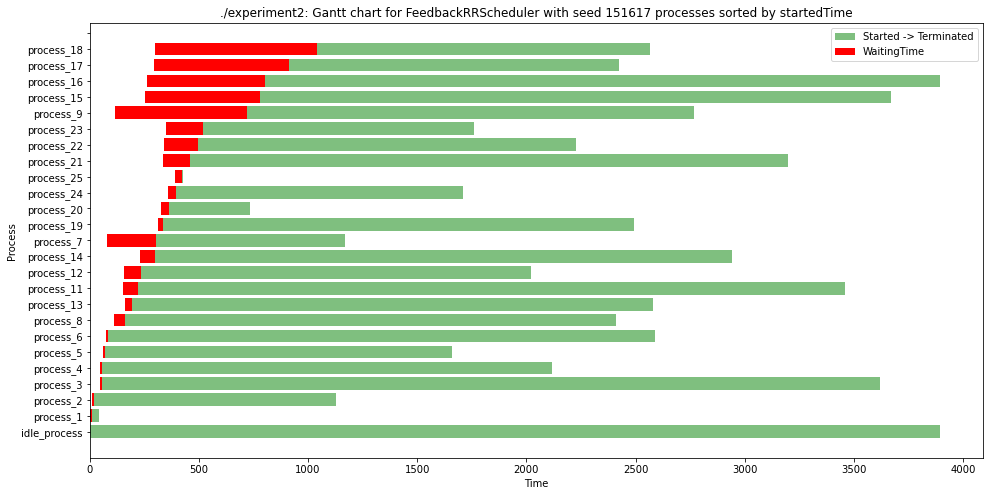

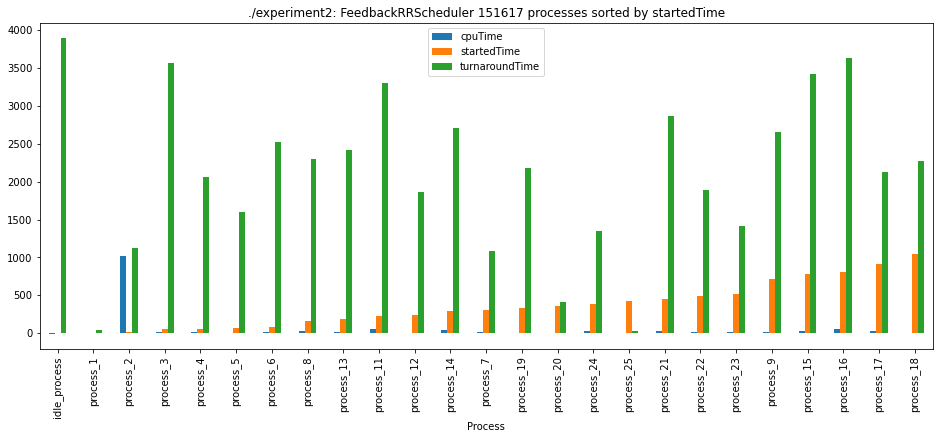

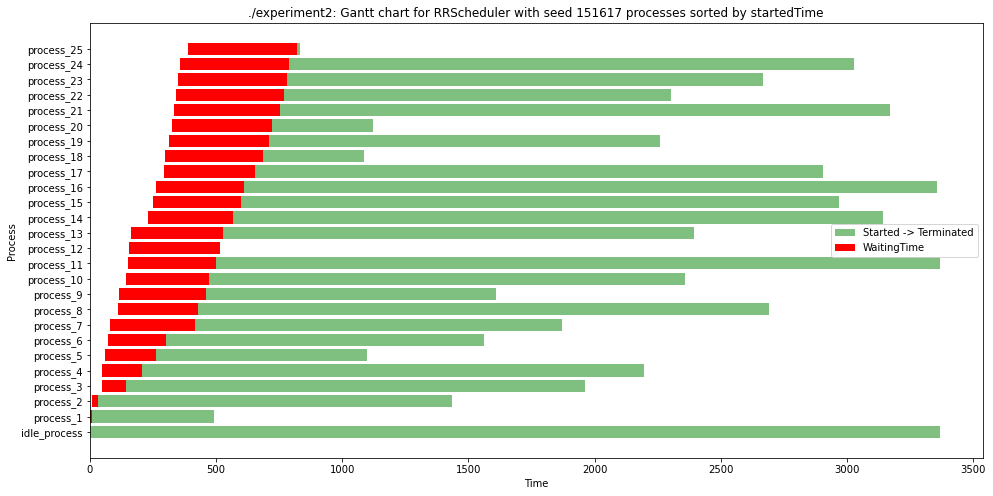

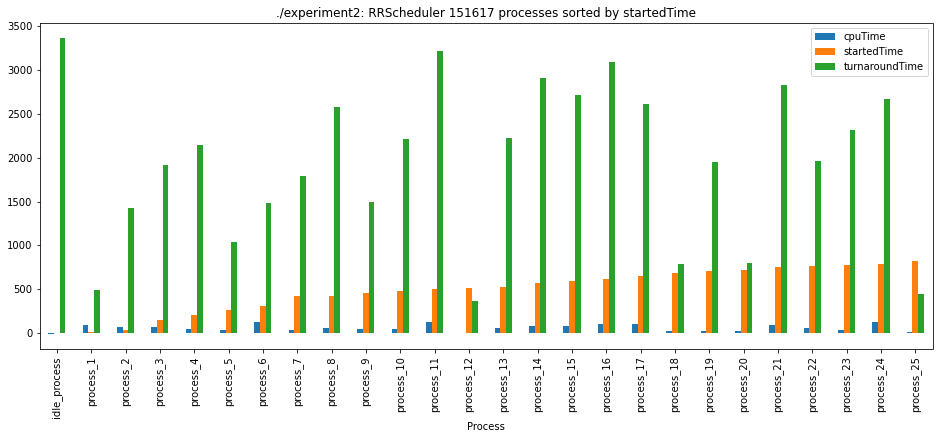

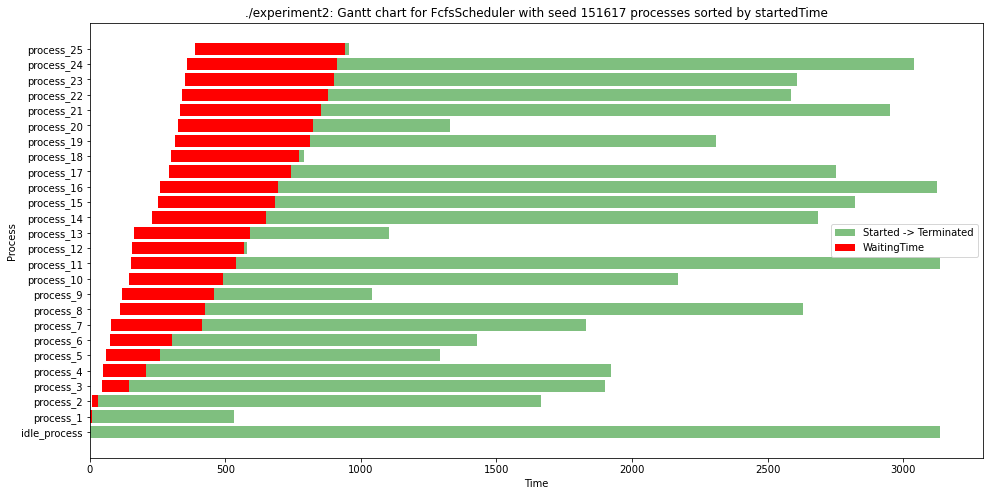

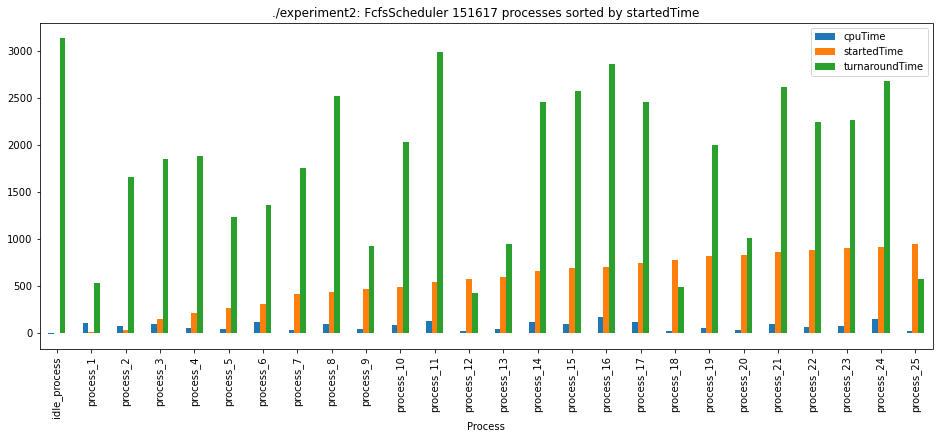

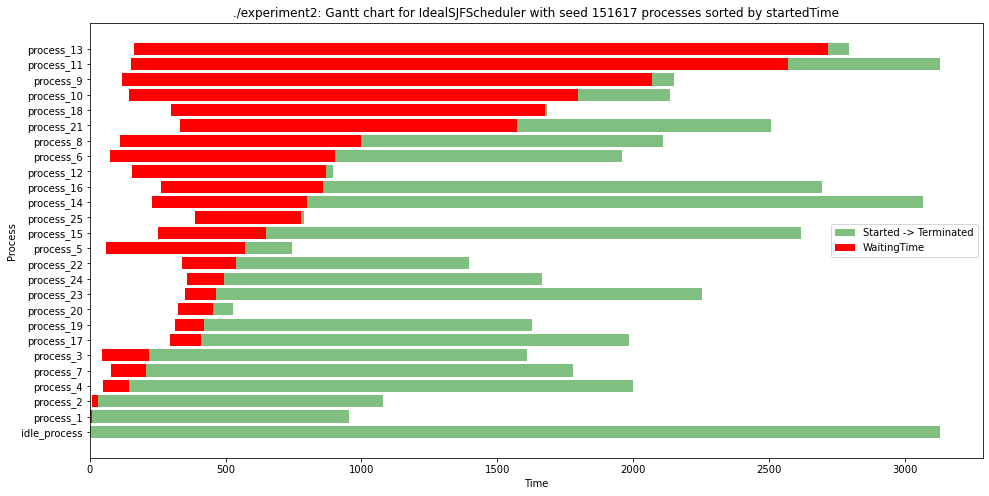

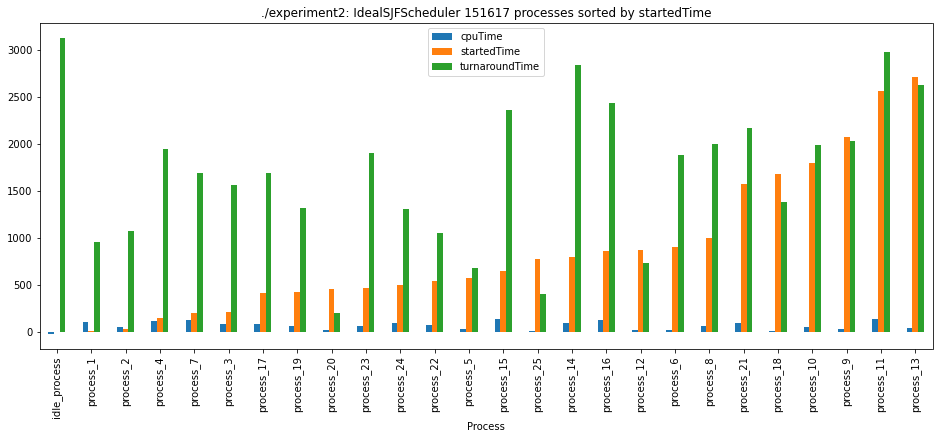

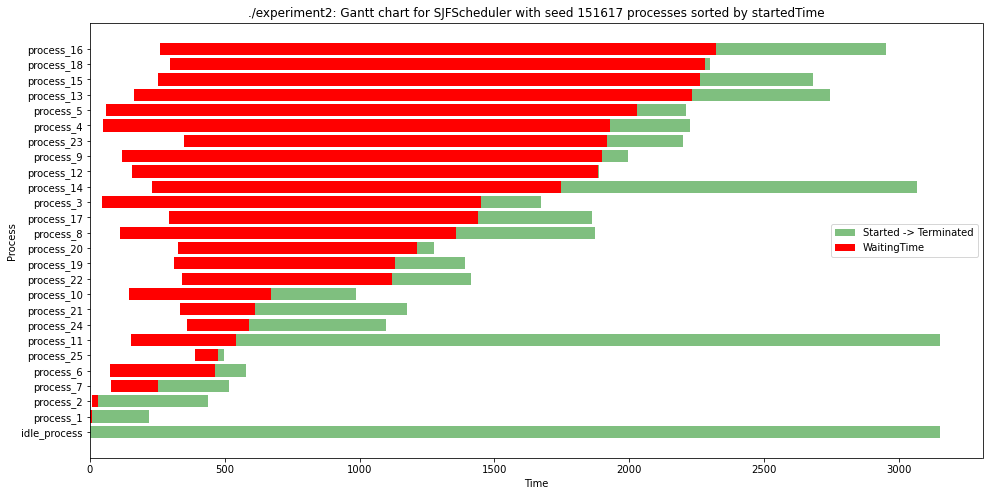

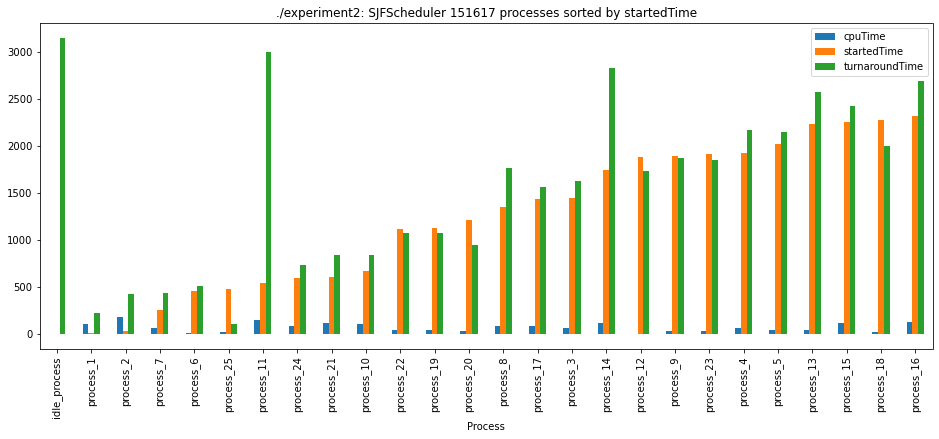

In [9]:
seed_to_analyse = "151617"
schedulers = ['FeedbackRRScheduler', 'RRScheduler', 'FcfsScheduler', 'IdealSJFScheduler', 'SJFScheduler']



def show_results(exp, scheduler, seed_to_analyse):
	exp.plot_gantt(scheduler, seed_to_analyse)
	exp.plot_cols_for_output(scheduler, seed_to_analyse)
	util = exp.calculate_cpu_utilization_for_output(scheduler, seed_to_analyse)

	output_for_seed = exp.get_output_for_seed(scheduler, seed_to_analyse)

	results.loc[len(results)] = [
		seed_to_analyse, 
		scheduler,
		output_for_seed.waitingTime.mean(),
		output_for_seed.turnaroundTime.mean(),
		output_for_seed.responseTime.mean(),
		util]
	
	print(f"CPU Utilization for {scheduler}: {util.round(3)}%")
	

for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)



### Results for Seed 91011

Here it is notable how the FeedbackRRScheduler does not have the highest CPU utilization. As noted in the last experiment, the FeedbackRRScheduler has a large variance in CPU utilization depending on workload in comparison to other algorithms

Here it is notable how the FeedbackRRScheduler does not have the highest CPU utilization. As noted in the last experiment, the FeedbackRRScheduler has a large variance in CPU utilization depending on workload in comparison to other algorithms
CPU Utilization for FeedbackRRScheduler: 98.985%
CPU Utilization for RRScheduler: 98.995%
CPU Utilization for FcfsScheduler: 98.991%
CPU Utilization for IdealSJFScheduler: 98.995%
CPU Utilization for SJFScheduler: 98.995%


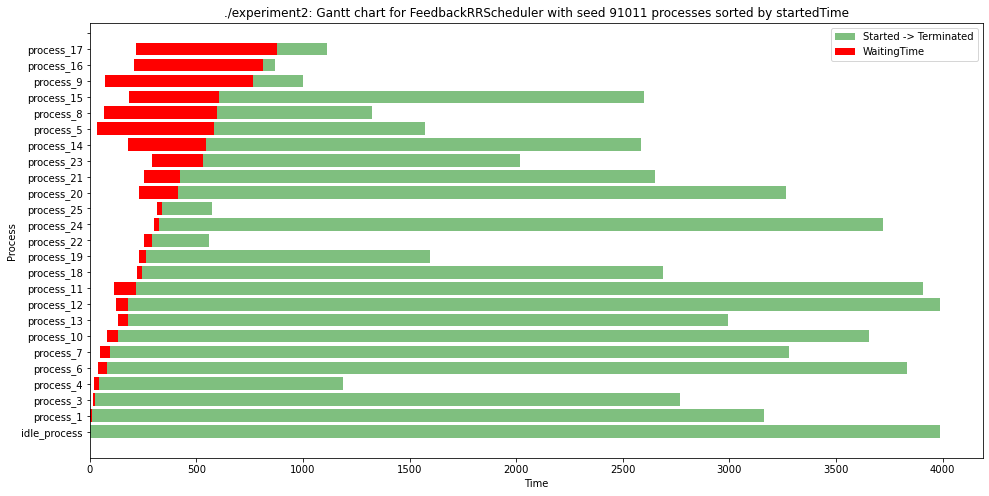

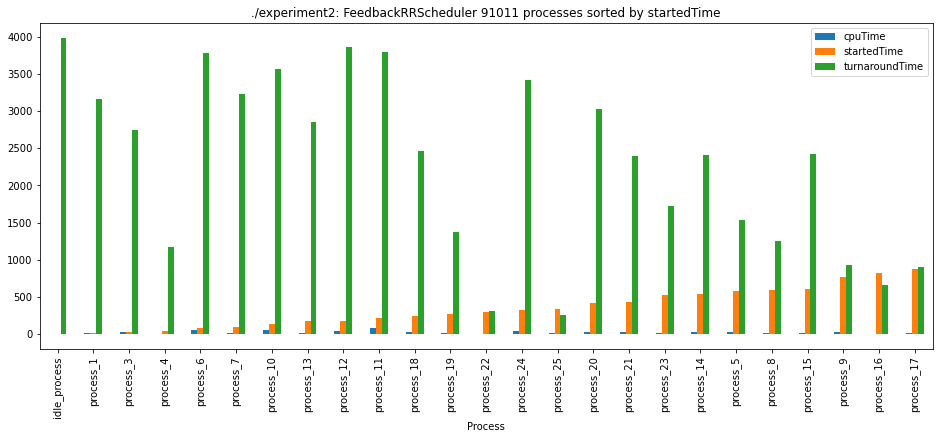

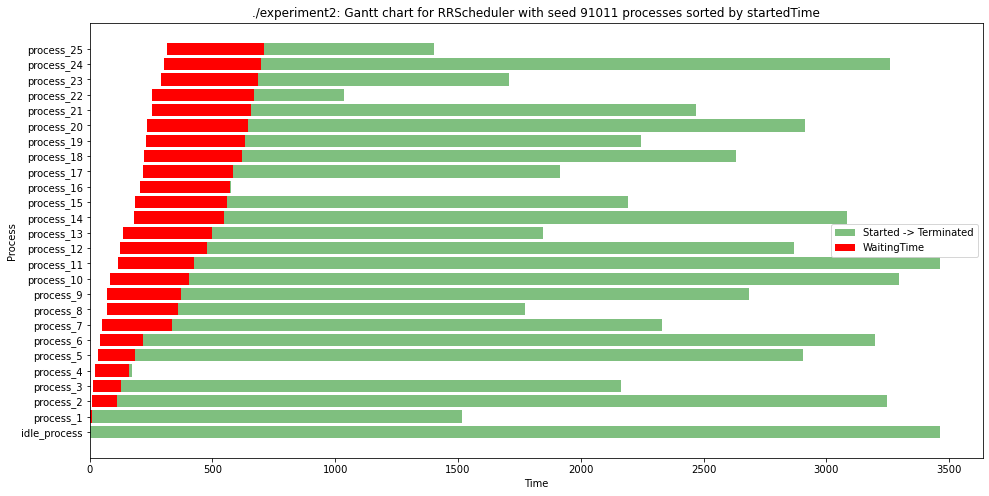

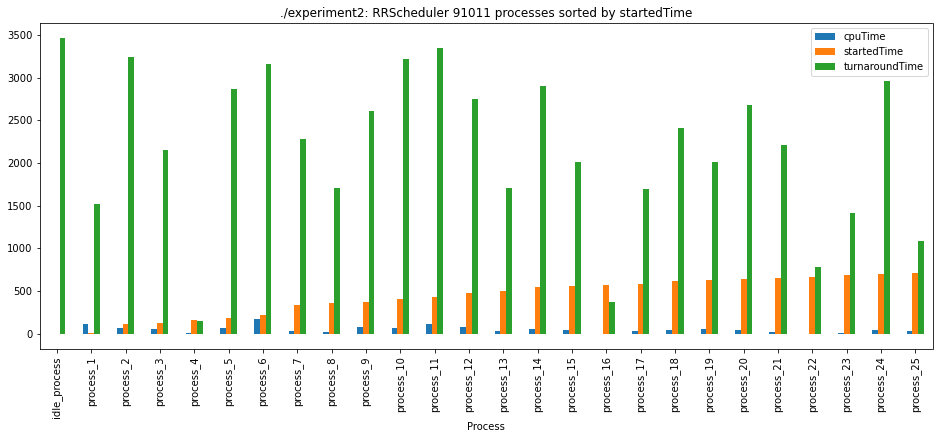

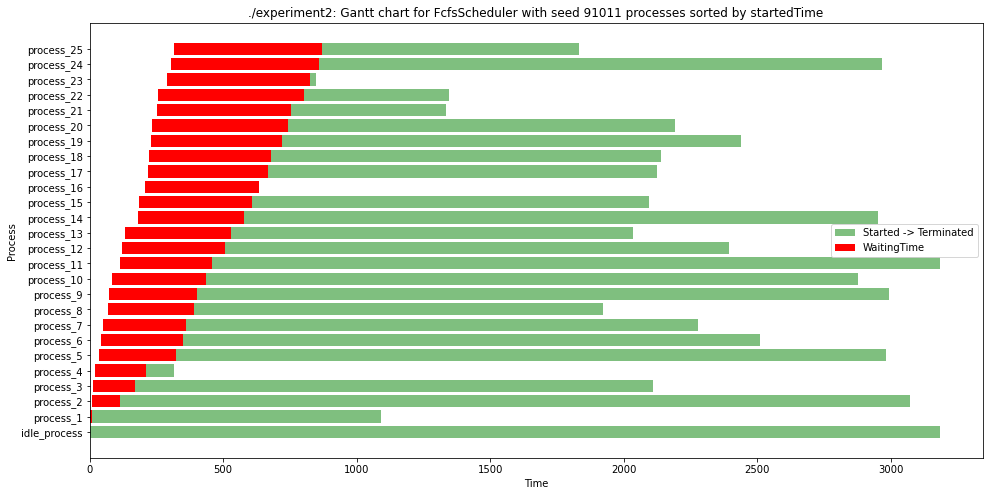

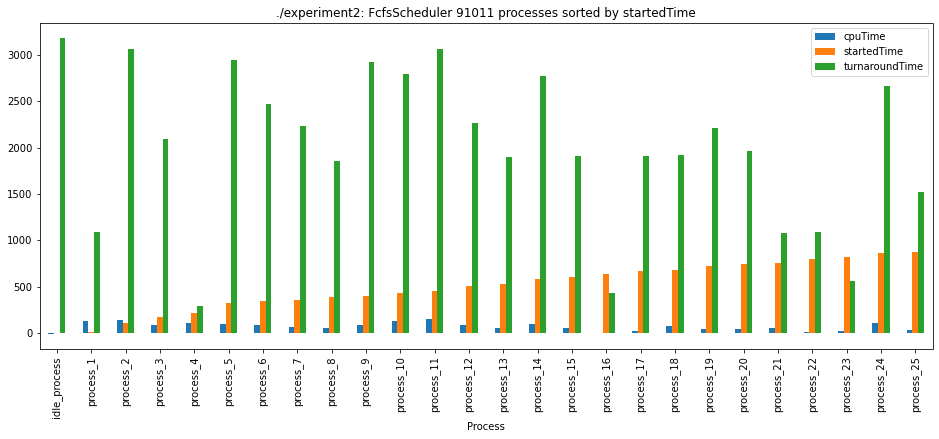

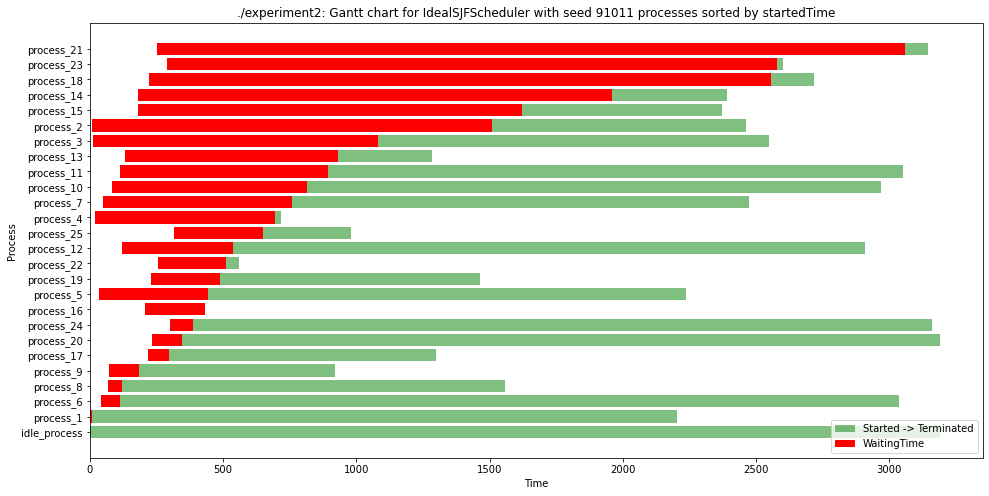

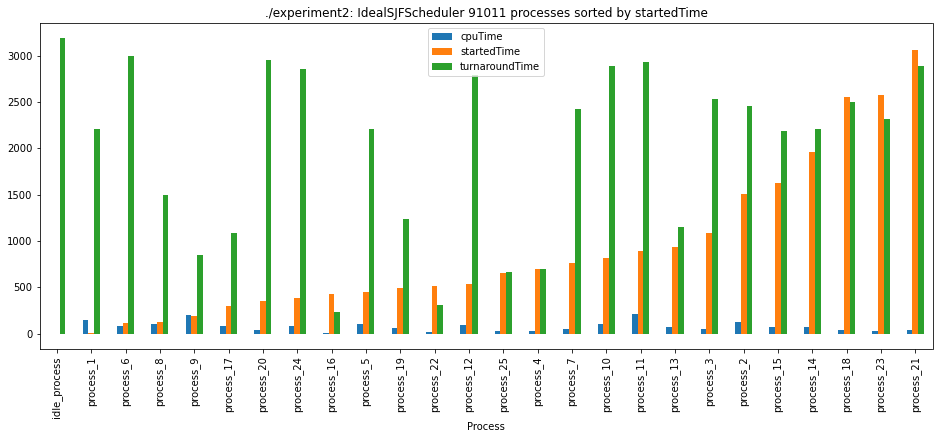

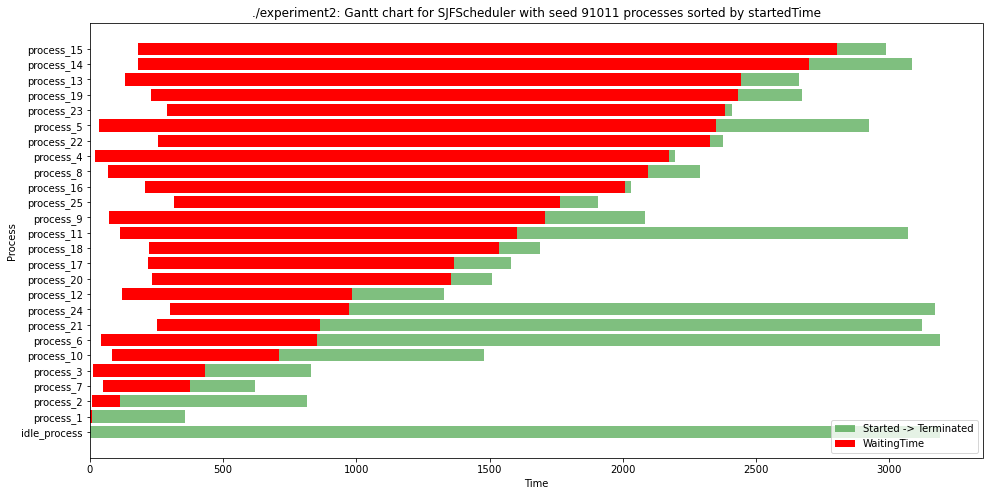

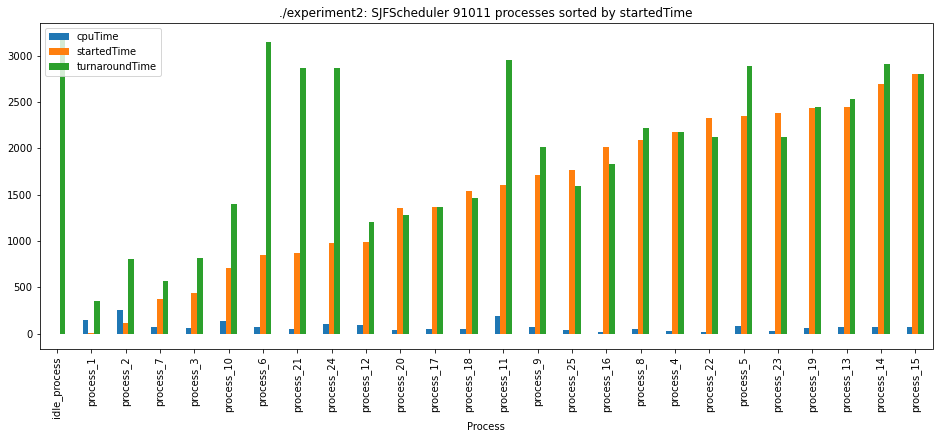

In [10]:
seed_to_analyse = '91011'
print("Here it is notable how the FeedbackRRScheduler does not have the highest CPU utilization. As noted in the last experiment, the FeedbackRRScheduler has a large variance in CPU utilization depending on workload in comparison to other algorithms")

for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)

### Results for Seed 121314

CPU Utilization for FeedbackRRScheduler: 99.219%
CPU Utilization for RRScheduler: 98.987%
CPU Utilization for FcfsScheduler: 98.985%
CPU Utilization for IdealSJFScheduler: 98.993%
CPU Utilization for SJFScheduler: 98.999%


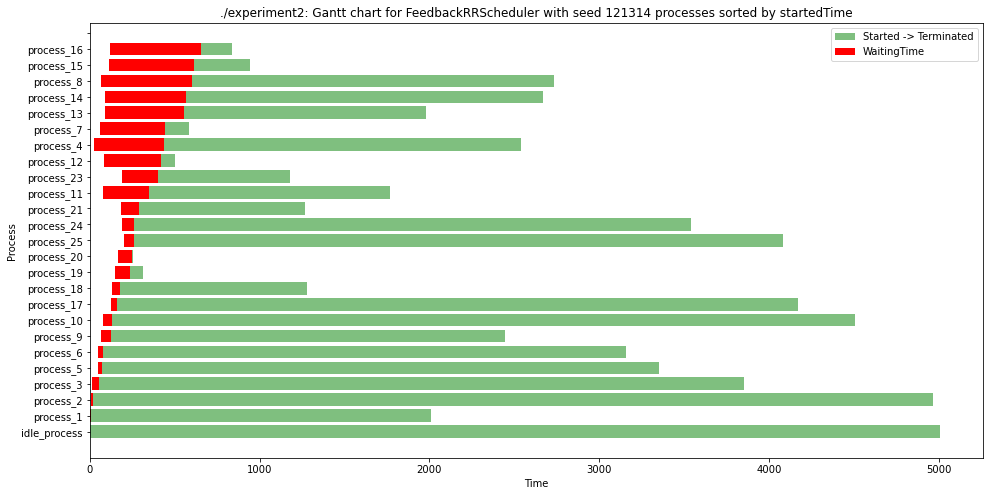

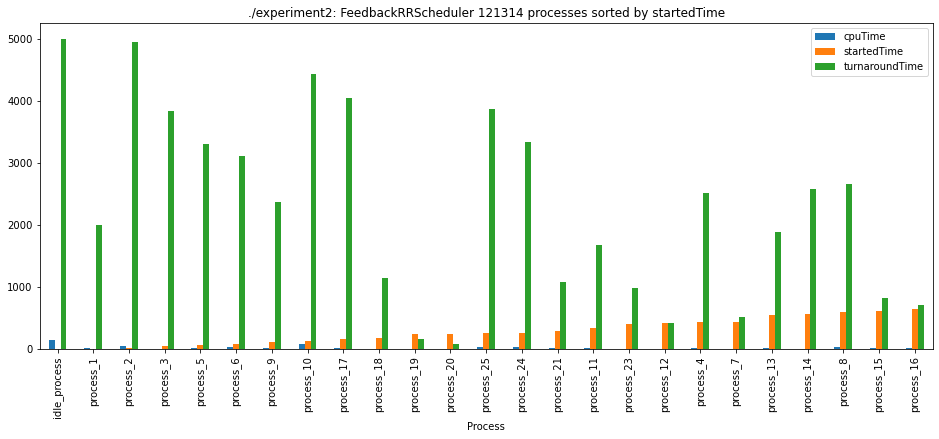

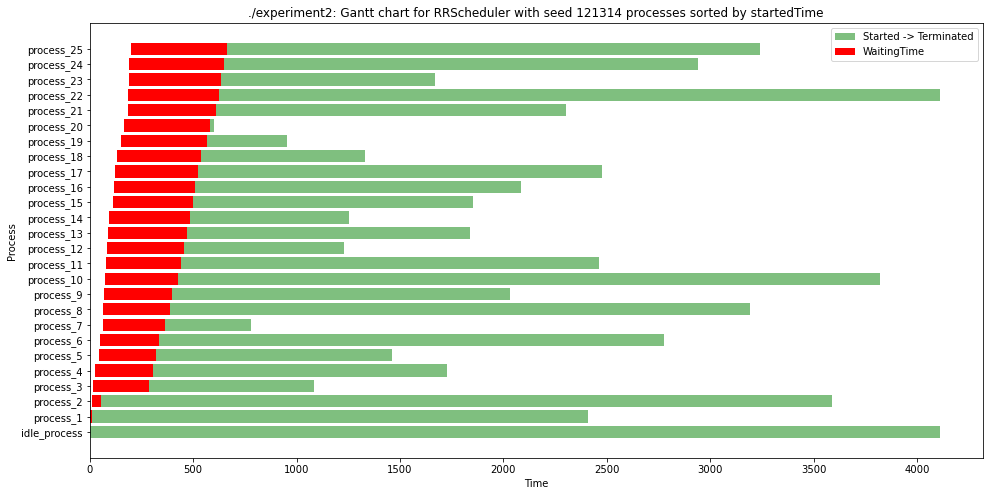

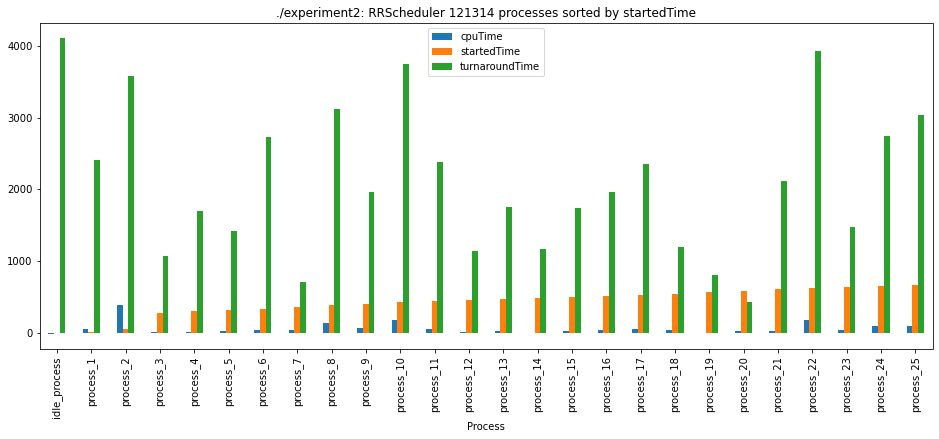

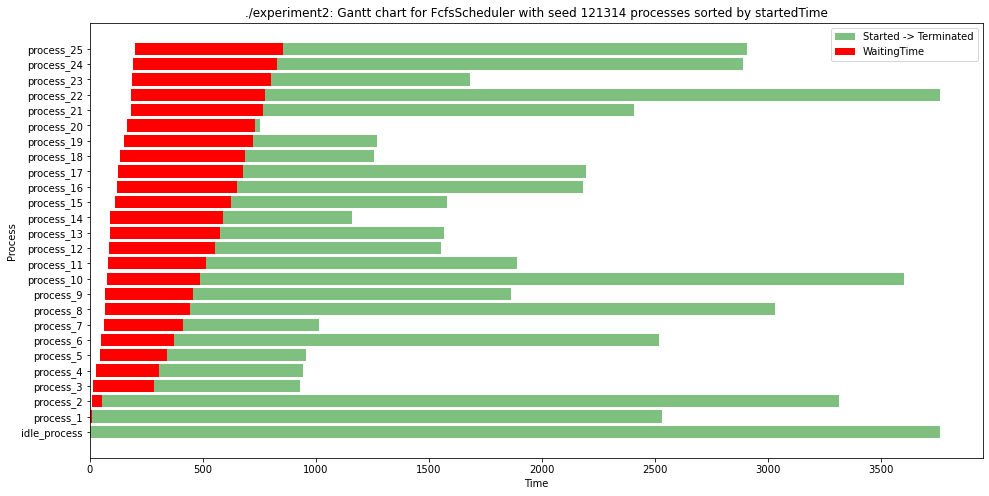

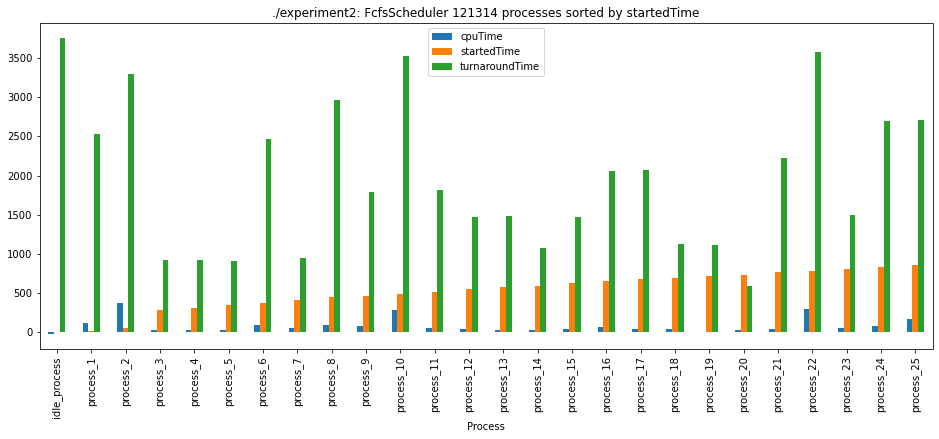

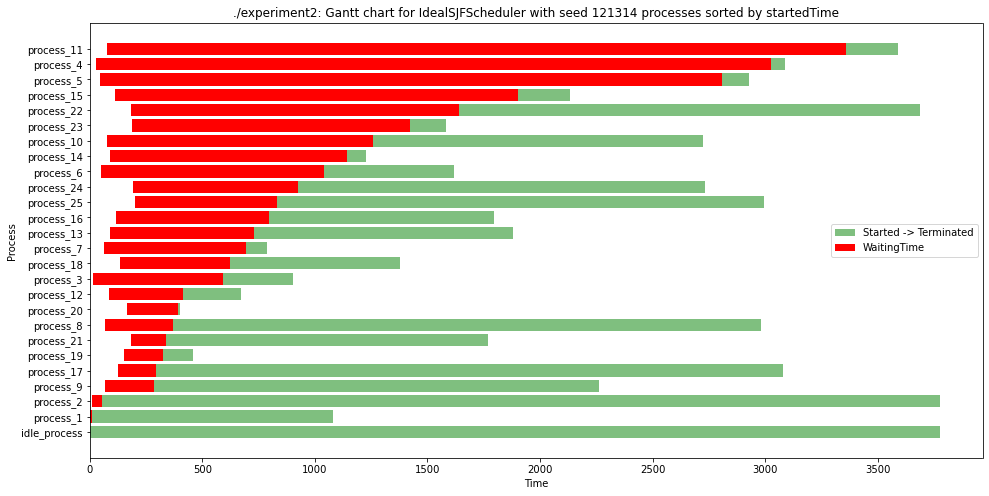

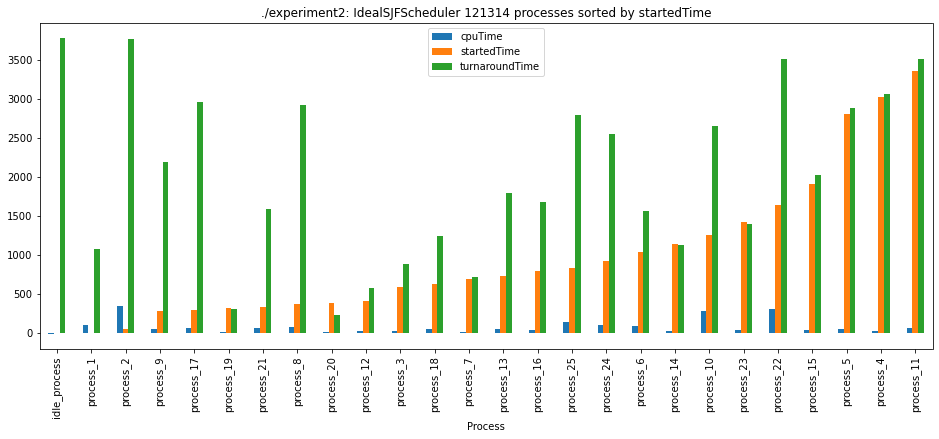

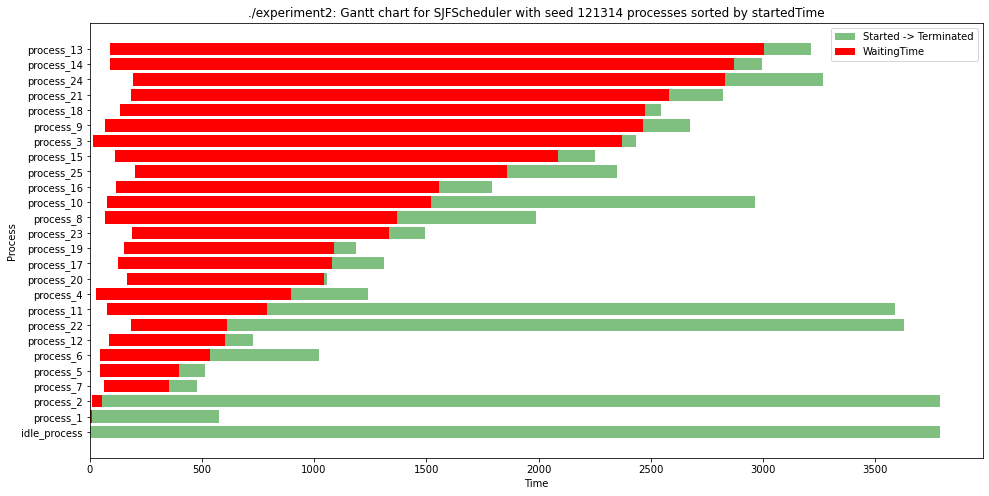

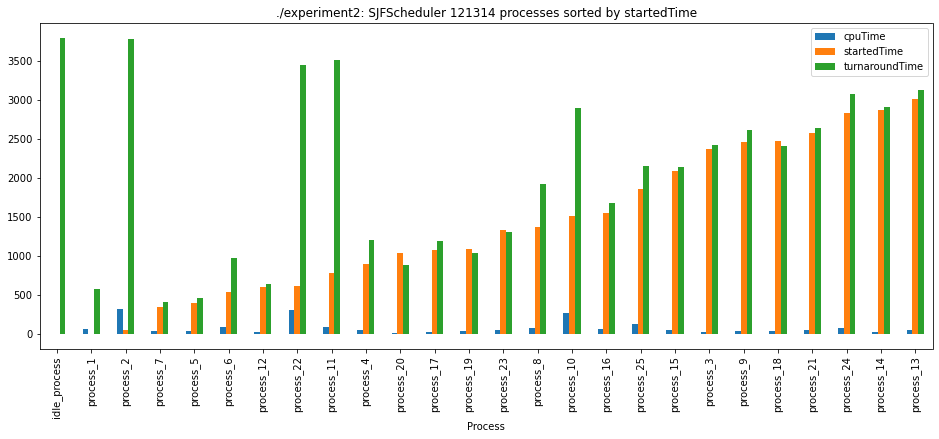

In [11]:
seed_to_analyse = '121314'

for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)

### Results for Seed 1234

CPU Utilization for FeedbackRRScheduler: 99.219%
CPU Utilization for RRScheduler: 98.987%
CPU Utilization for FcfsScheduler: 98.985%
CPU Utilization for IdealSJFScheduler: 98.993%
CPU Utilization for SJFScheduler: 98.999%


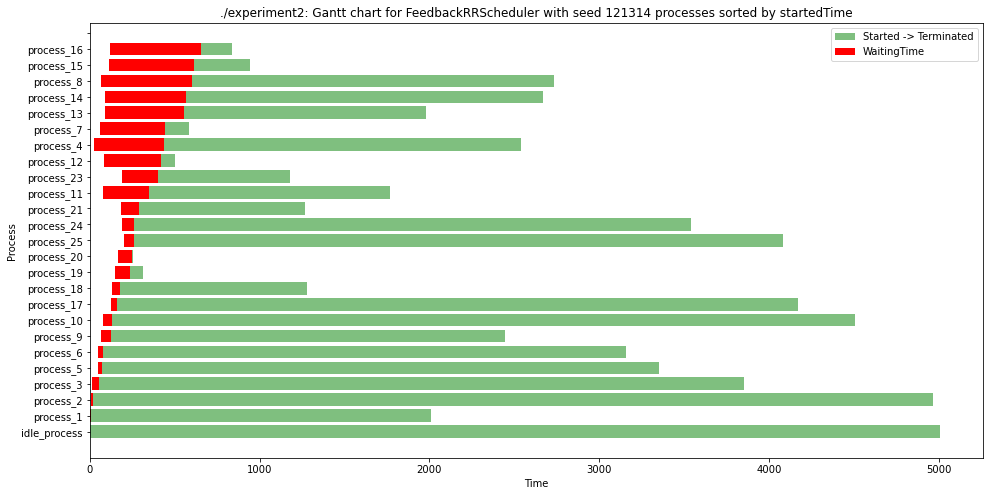

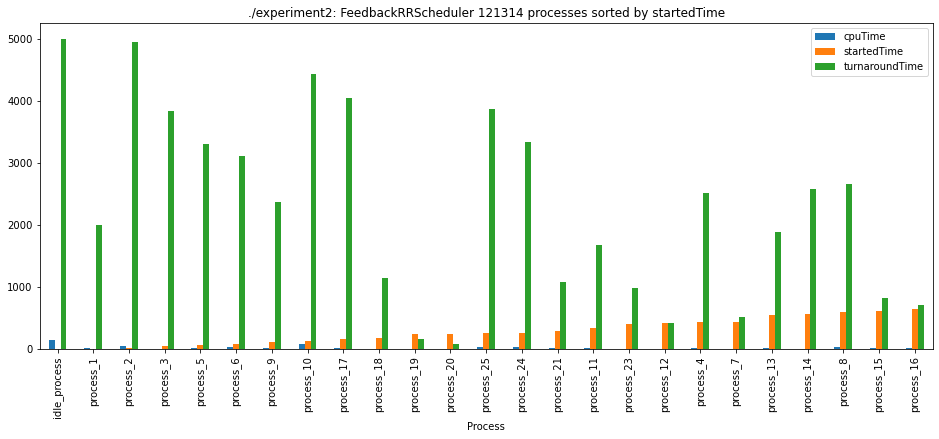

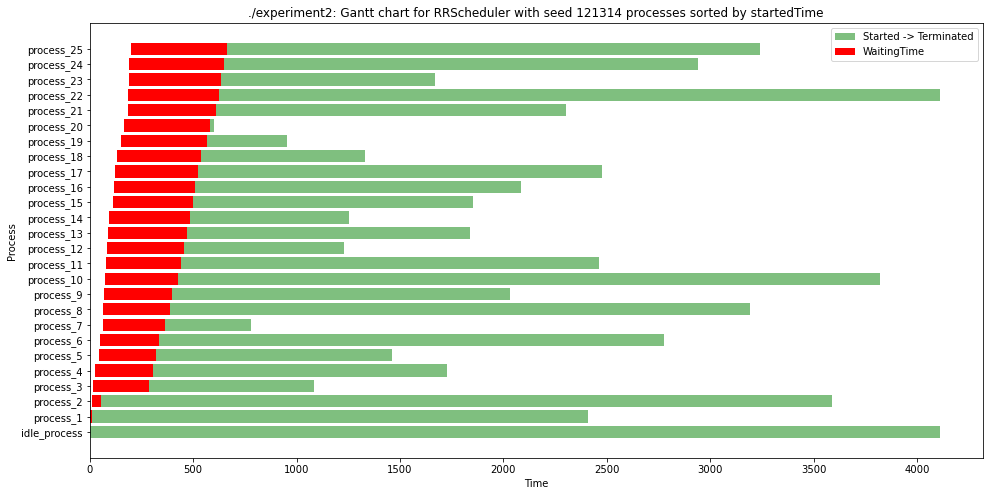

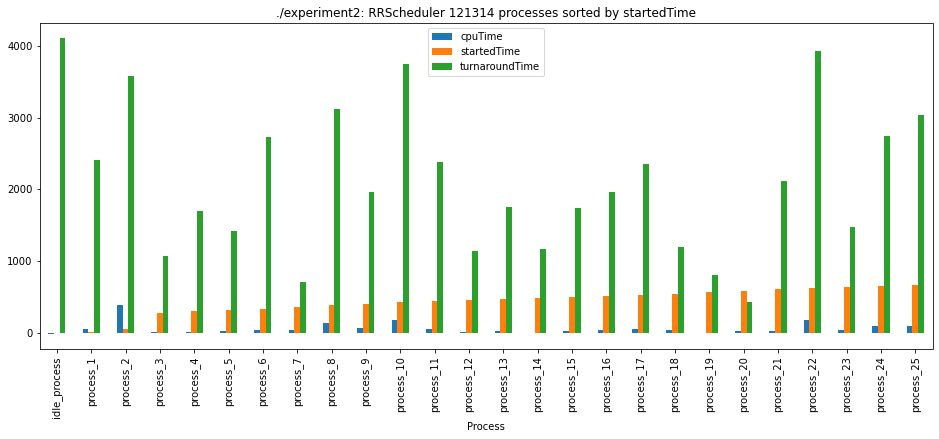

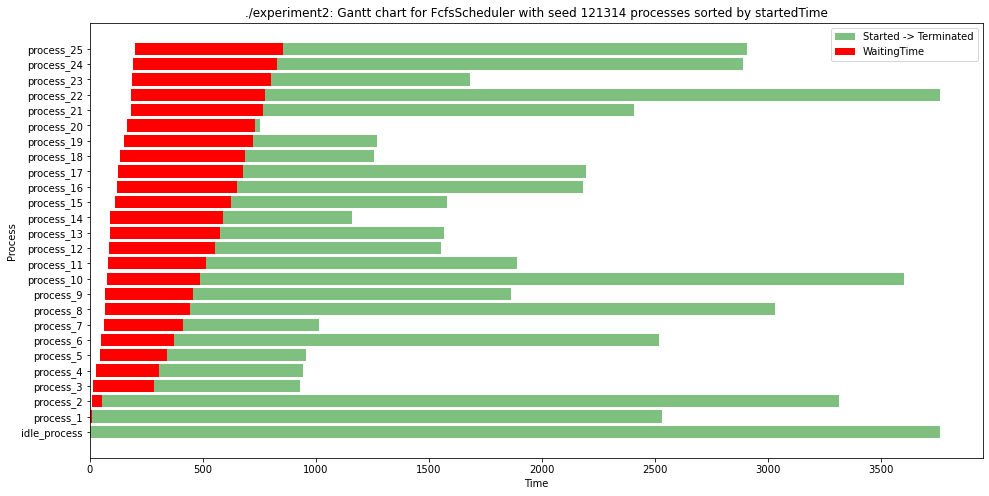

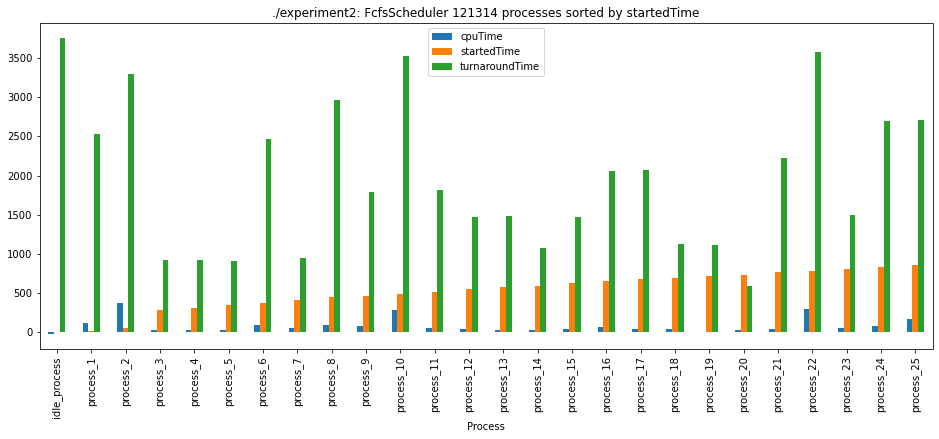

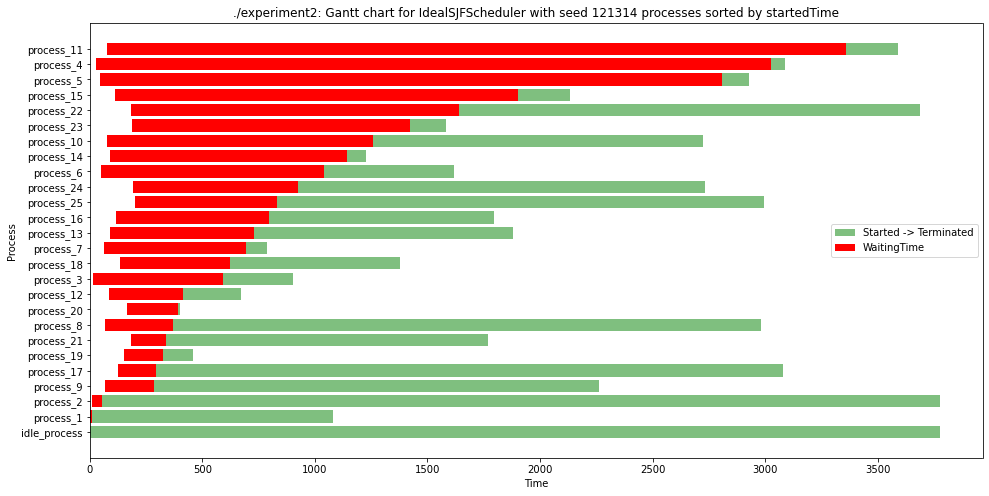

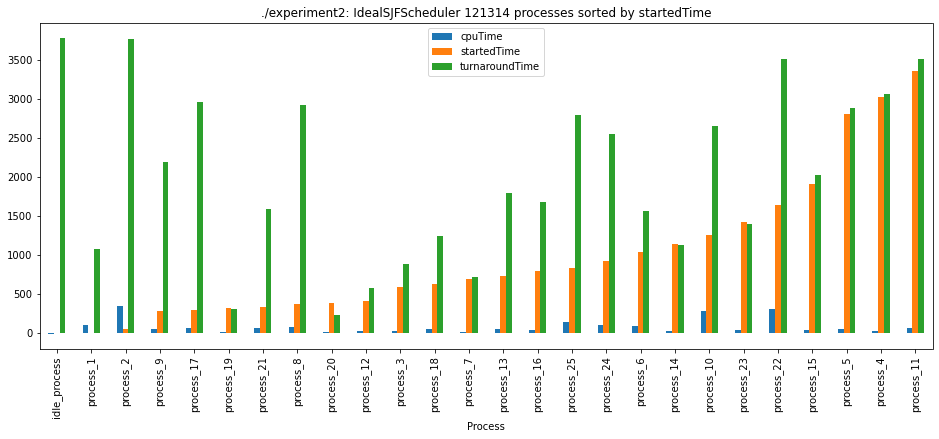

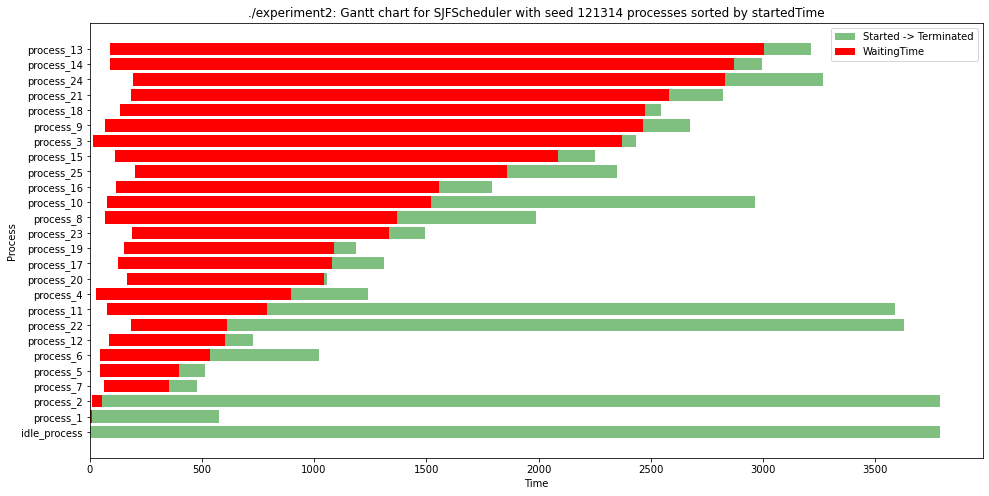

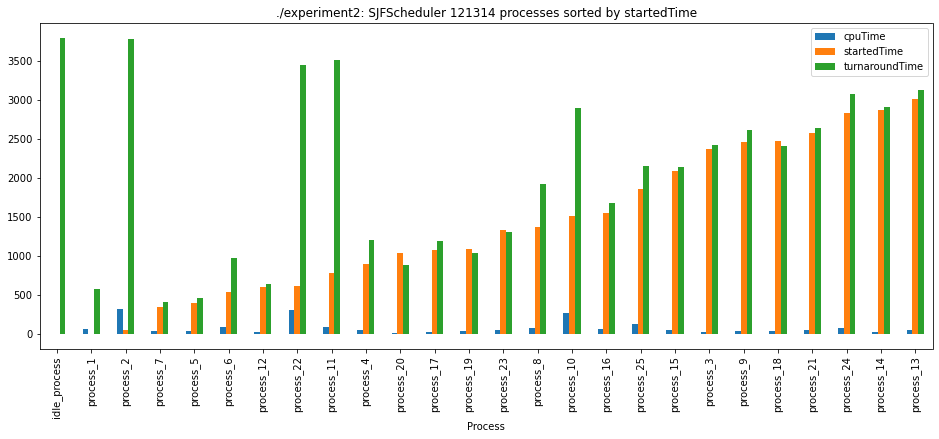

In [12]:
seed_to_analyse = '121314'

for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)

### Results for Seed 5678

CPU Utilization for FeedbackRRScheduler: 99.937%
CPU Utilization for RRScheduler: 99.003%
CPU Utilization for FcfsScheduler: 98.995%
CPU Utilization for IdealSJFScheduler: 99.0%
CPU Utilization for SJFScheduler: 98.997%


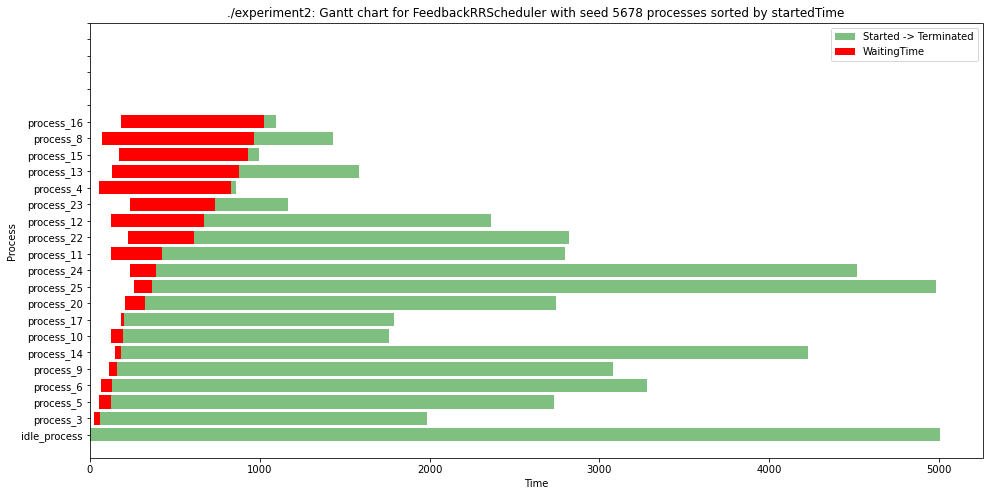

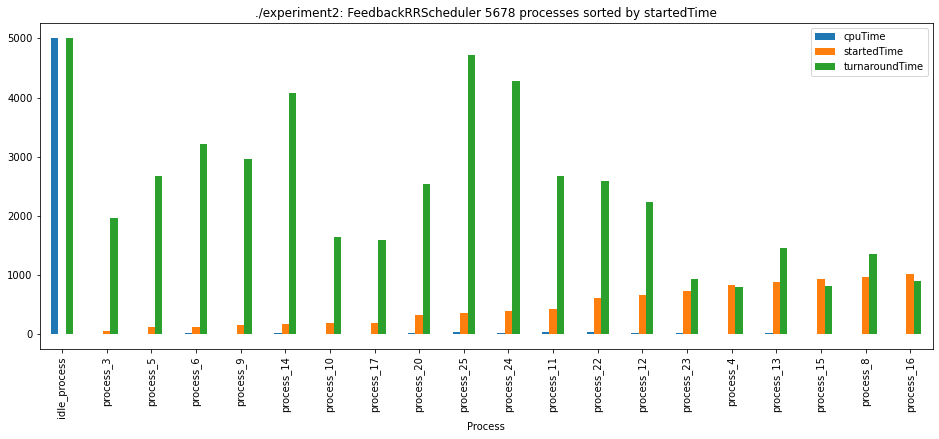

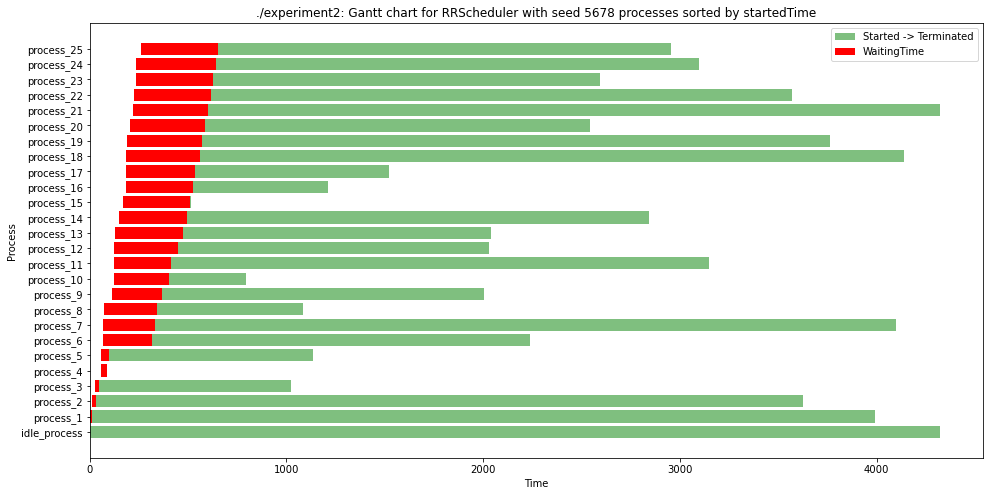

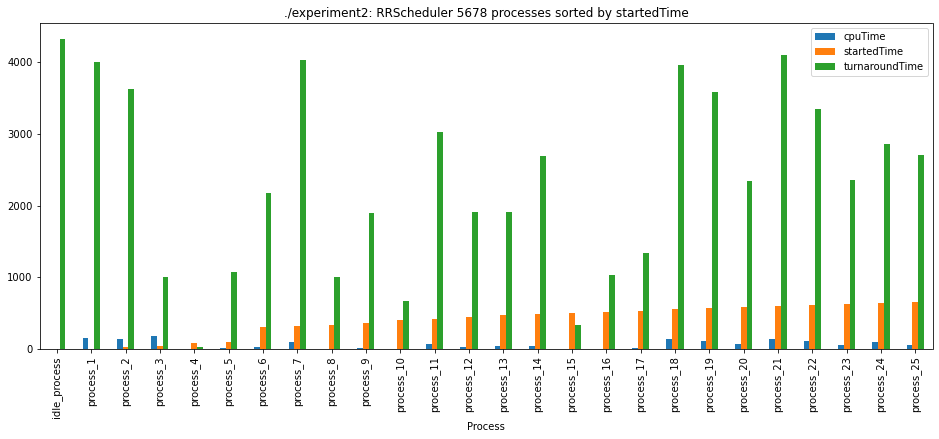

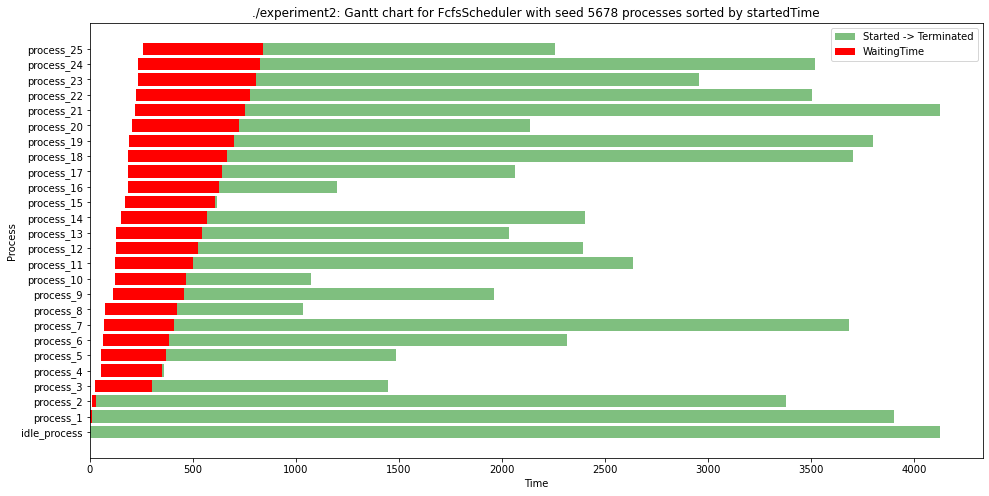

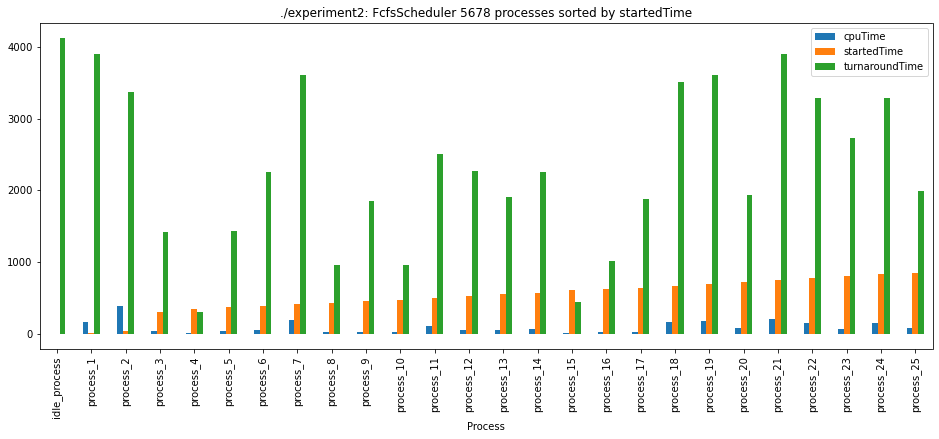

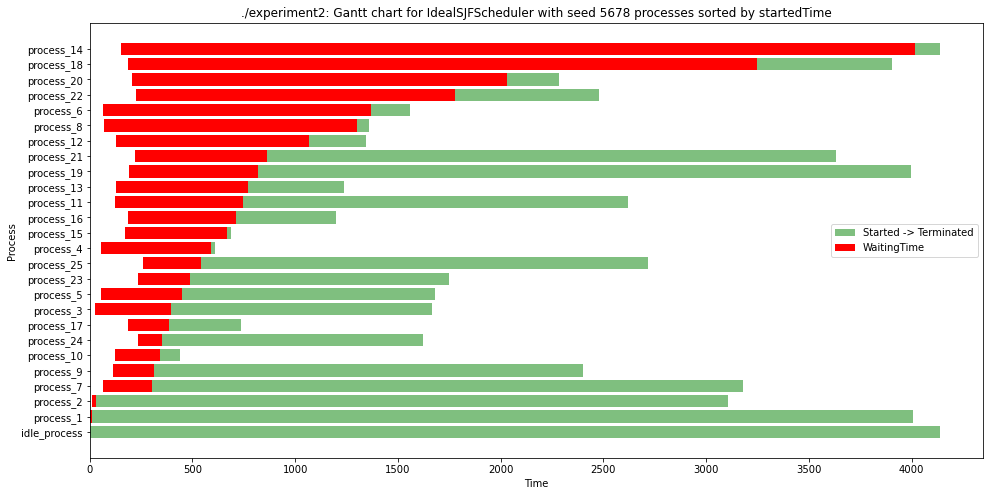

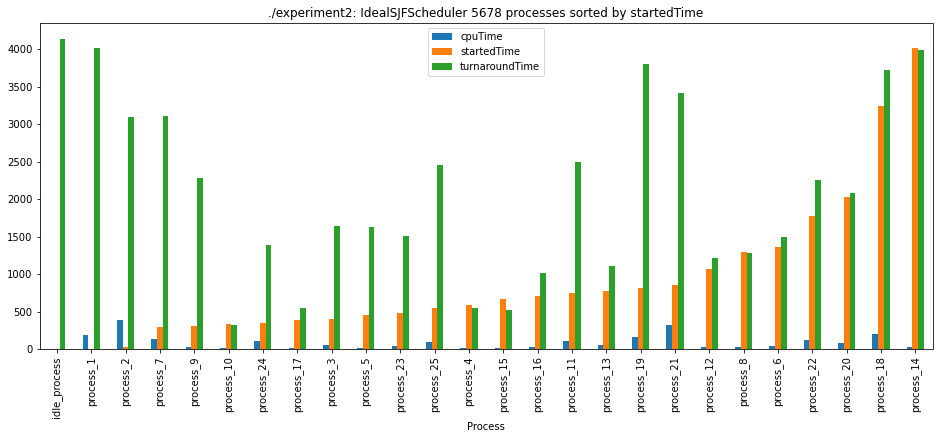

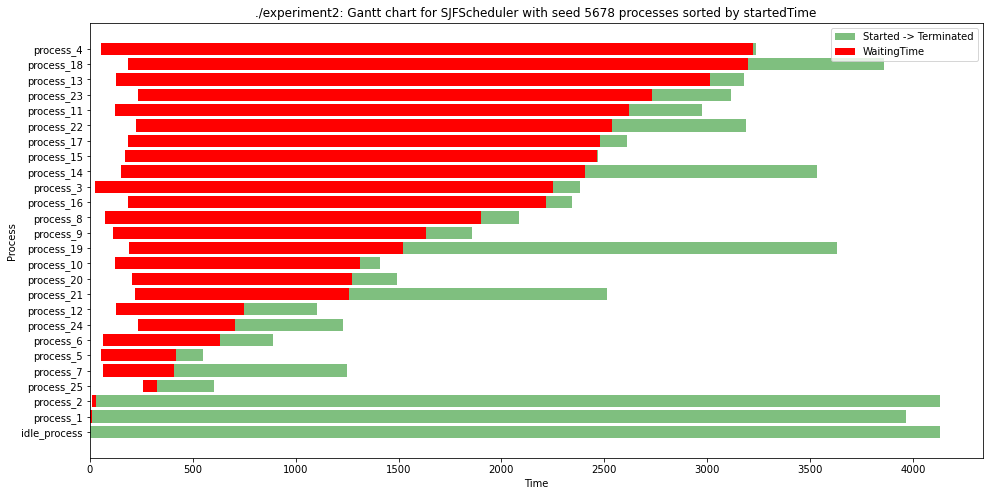

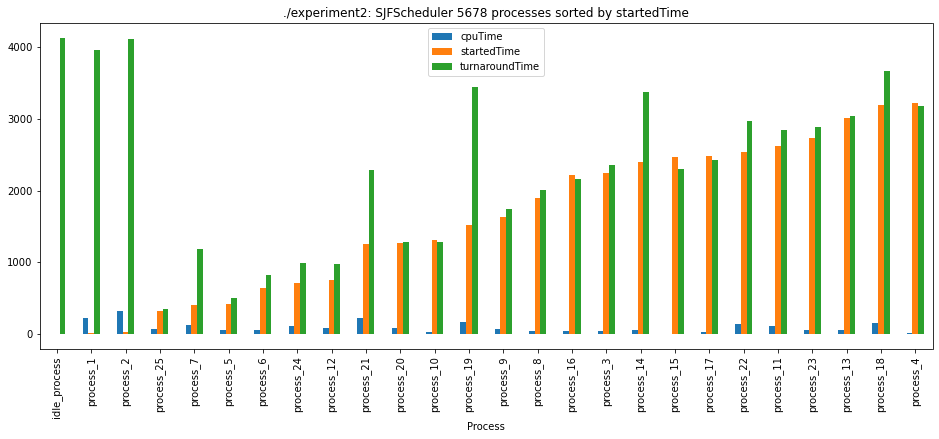

In [13]:
seed_to_analyse = '5678'

for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)
	

In [14]:
## Results of The Experiment
results

,Seed,Scheduler,MeanWaitingTime,MeanTurnaroundTime,MeanResponseTime,CpuUtilization
0,151617,FeedbackRRScheduler,174.440000,2108.920000,168.080000,98.989879
1,151617,RRScheduler,307.500000,1955.923077,301.153846,98.988142
2,151617,FcfsScheduler,360.307692,1823.500000,353.961538,98.988864
3,151617,IdealSJFScheduler,672.000000,1706.346154,665.653846,98.984650
4,151617,SJFScheduler,1042.538462,1563.307692,1036.192308,98.997208
5,91011,FeedbackRRScheduler,202.920000,2289.960000,197.120000,98.985348
6,91011,RRScheduler,298.769231,2181.192308,292.653846,98.994788
7,91011,FcfsScheduler,365.538462,2007.576923,359.423077,98.991276
8,91011,IdealSJFScheduler,749.961538,2008.615385,743.846154,98.994681
9,91011,SJFScheduler,1341.538462,1997.153846,1335.423077,98.994681


Now we must calculate the means for each metric for all of our scheduling algorithm over the 5 seeds.

In [15]:
means = results.groupby(['Scheduler']).mean()
stds = results.groupby(['Scheduler']).std()


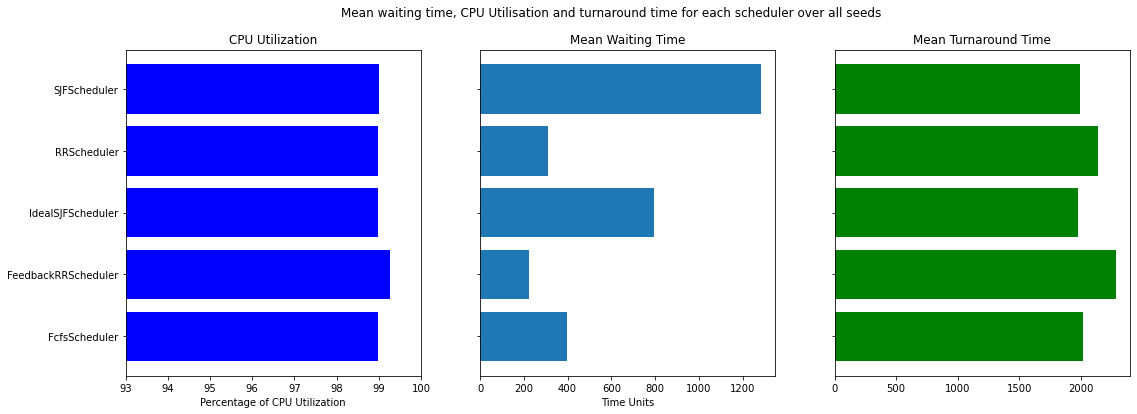

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey='all',)

fig.set_size_inches(18, 6)

fig.suptitle("Mean waiting time, CPU Utilisation and turnaround time for each scheduler over all seeds")

ax1.set_xlabel("Percentage of CPU Utilization")
ax1.barh(means.index, means['CpuUtilization'], color='b')
ax1.set_title("CPU Utilization")
ax1.set_xbound(93, 100)

ax2.set_xlabel("Time Units")
ax2.barh(means.index, means['MeanWaitingTime'])

ax2.set_title("Mean Waiting Time")
ax3.barh(means.index, means['MeanTurnaroundTime'], color='g')
ax3.set_title("Mean Turnaround Time")
ax2.set_xlabel("Time Units")

plt.show()

The results above outline the Mean CPU Utilization, Mean Waiting Time and Mean Turnaround Time for each scheduling algorithm over all seeds. As we saw in the previous experiment, the Mean Waiting Time for the Feedback Round Robin (FRR) algorithm is the lowest, whilst the Shortest Job First algorithm suffers from starvation of longer processes.

### Comparing CPU Utilization

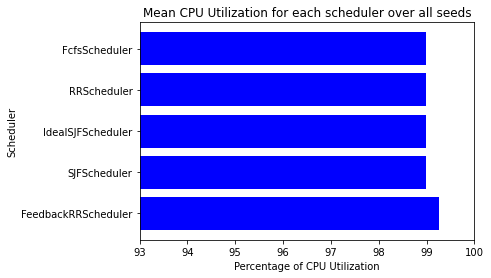

In [17]:
utilisation = pd.DataFrame(means.CpuUtilization).sort_values('CpuUtilization', ascending=False)

## Std Deviation of the Results


plt.barh(utilisation.index, utilisation['CpuUtilization'], color='b')
plt.title("Mean CPU Utilization for each scheduler over all seeds")
plt.xlabel("Percentage of CPU Utilization")
plt.ylabel("Scheduler")

plt.xlim(93, 100)

plt.show()





Above we can see that CPU Utilization for each of the different algorithms is very similar, with FRR having the highest CPU utilization but only slightly higher than the other algorithms. We can see in better detail below how the CPU Utilization of each of the algorithms compares from the table below.

In [18]:
utilisation

,CpuUtilization
Scheduler,
FeedbackRRScheduler,99.270131
SJFScheduler,98.997410
IdealSJFScheduler,98.993167
RRScheduler,98.992154
FcfsScheduler,98.988893


Looking at the above table, the FRR algorithm has the best average CPU utilization over all the seeds leading by about `0.223%` compared to the Shortest Job First Algorithm. Comparing the utilisation of the other algorithms, we can see that this is by far the largest margin between two consecutive algorithms. With each of the other algorithms only differing by less than `0.01%`. This leads us to the conclusion that the Multilevel Feedback Queue is an improvement over the other algorithms when it comes to maximizing CPU utilization. However, we should take a look at the standard deviation of the CPU utilization for each algorithm to ensure that this conclusion is accurate.

,StdDeviation
Scheduler,
FeedbackRRScheduler,0.390494
RRScheduler,0.006804
IdealSJFScheduler,0.005645
FcfsScheduler,0.004331
SJFScheduler,0.001813


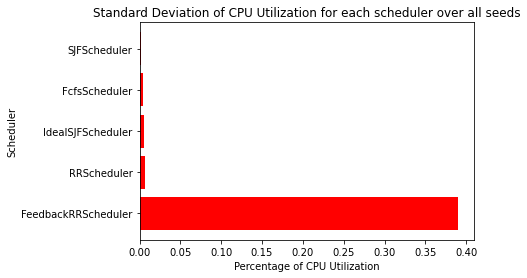

In [19]:
utilisation_std = pd.DataFrame(stds.CpuUtilization).sort_values('CpuUtilization', ascending=False)

utilisation_std.rename(columns={'CpuUtilization': 'StdDeviation'}, inplace=True)


plt.title("Standard Deviation of CPU Utilization for each scheduler over all seeds")
plt.barh(utilisation_std.index, utilisation_std['StdDeviation'], color='r')
plt.xlabel("Percentage of CPU Utilization")
plt.ylabel("Scheduler")

utilisation_std

Notably, we can see that my initial conclusion: that the Feedback Round Robin algorithm was an improvement in terms of CPU utilization may be incorrect. This is since, upon analyzing standard deviation, we can see that the standard deviation for the Feedback Round Robin Scheduler is far higher than any other the others. This shows that the Feedback Round Round Scheduler is not the best algorithm for maximizing CPU utilization, but actually that its CPU utilization varies greatly from seed to seed, implying that the performance of the algorithm is highly dependent on the input parameters/data.

### Comparing Average Turnaround Time

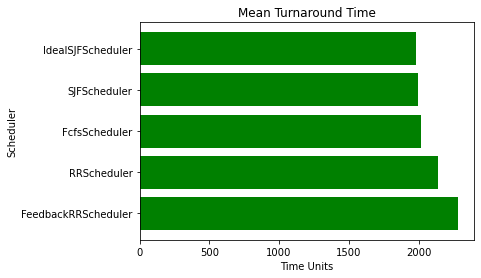

,MeanTurnaroundTime
Scheduler,
FeedbackRRScheduler,2285.914000
RRScheduler,2142.146154
FcfsScheduler,2017.584615
SJFScheduler,1994.300000
IdealSJFScheduler,1978.723077


In [20]:
turnaround = pd.DataFrame(means.MeanTurnaroundTime).sort_values('MeanTurnaroundTime', ascending=False)
plt.barh(turnaround.index, turnaround['MeanTurnaroundTime'], color='g')
plt.title("Mean Turnaround Time")
plt.xlabel("Time Units")
plt.ylabel("Scheduler")

plt.show()

turnaround

The above table shows us that the average turnaround time for the pre-emptive Ideal Shortest Job First is the lowest, whilst the non-preemptive version has the next lowest mean turnaround time. The Round Robin Scheduler and Feedback Round Robin Scheduler have the worst average turnaround time, this is due to the fact that the Round Robin algorithms are using a time quantum to ensure that the processes are forced to context switch even if they have not yet terminated. This means that in Round Robin algorithms, the current burst will not be finished if the time quantum has been reached. Here, the Feedback RR Scheduler performs particularly poorly when it comes to turnaround time even when compared to the simple Round Robin scheduler. This is likely due to the policy of the scheduler which demotes a process once it has reached it's time quantum, this forces longer processes to wait longer than they would have to if the scheduler was using a simple round robin approach. 

### Conclusion

As was noted above, the Feedback RR Scheduler has the best average CPU utilisation over the 5 seeds, followed by the Shortest Job First algorithm. The Shortest Job First algorithm has the best average turnaround time over the 5 seeds whilst the Feedback RR Scheduler has the worst average turnaround time. This leads us to the conclusion that if the goal is to maximize CPU utilization whilst also minimising average turnaround time, the preemptive Shortest Job First algorithm is the most effective. However, it must be noted that when waiting time is concerned, the Shortest Job First Algorithm may suffer from starvation when faced with large workloads with many smaller processes and fewer larger ones.

When considering which algorithm to use, it is important to keep in mind the workload that the scheduler needs to handle. In a system handling consistently small request sizes, with little variation, so that starvation wouldn't be a problem, the best algorithm to opt for is the Shortest Job First algorithm as it will keep CPU utilisation high whilst also ensuring Turnaround time is optimal. If we arent as concerned with turnaround time, a round robin approach makes sense, as it allows us to maximise CPU usage and keep wait times low.

# Experiment 3 - When dealing with unpredictable & highly varying workloads, which algorithm performs best and can we improve the estimation of burst times from the shortest job first algorithm in this instance?

In [21]:
exp = Experiment('../experiment3')

## Introduction
For this experiment I am not going to be dealing with the Ideal Shortest Job First scheduler as it is able to preempt the burst time of arriving processes, since we are only dealing with unpredictable workloads, we will use the non-preemptive version of the scheduler as opposed to the pre-emptive version. I will compare the performance of each of the schedulers using highly unpredictable workloads, I will then compare them and analayse their performance, specifically looking to see if we can improve the estimation of the burst time done by the Shortest Job First algorithm.

## Methodology
To effectively analyse how each of the algorithms perform under unpredictable and highly varying workloads, I will compare the CPU Utilisation and Response Time for each of the algorithms over 5 seeds and will also analyse the Gantt Charts for each of the algorithms to compare their performance.

In [22]:
print(f"Seeds for Experiment 3: {exp.all_seeds()}")

Seeds for Experiment 3: ['5124', '1234', '5678', '6789', '91011']


### Input Parameters
Using each of the above seeds, I will be using the following input parameters for this experiment:

In [23]:
exp.input_params[1][1].drop(['seed'])

,value
param,
numberOfProcesses,30
staticPriority,0
meanInterArrival,20
meanCpuBurst,5
meanIoBurst,35
meanNumberBursts,4


The above input parameters are designed to create input data that is unpredictable due to the large number of processes and the large difference in CPU and IO burst times. I have chosen a high inter-arrival time as I am not attempting to put high strain on the scheduler, I am only interested in how the scheduler performs when it is unaware of the workload and how we can improve the estimation of burst time for highly unpredictable workloads.

### Simulator Parameters

I have chosen the following simulator parameters for this experiment. Note the poor estimate for initial burst and relatively high alpha burst times. I would like to look in depth at how these parameters can be optimized to improve the estimation of burst times. 

In [24]:
exp.sim_params[0].drop(['scheduler'])

,value
param,
timeLimit,5000
interruptTime,10
timeQuantum,20
initialBurstEstimate,30
alphaBurstEstimate,0.7
periodic,false


## Results

In [25]:
results = new_results()

### Results for Seed 1234

CPU Utilization for FeedbackRRScheduler: 98.959%
CPU Utilization for RRScheduler: 99.002%
CPU Utilization for FcfsScheduler: 98.999%
CPU Utilization for SJFScheduler: 98.988%


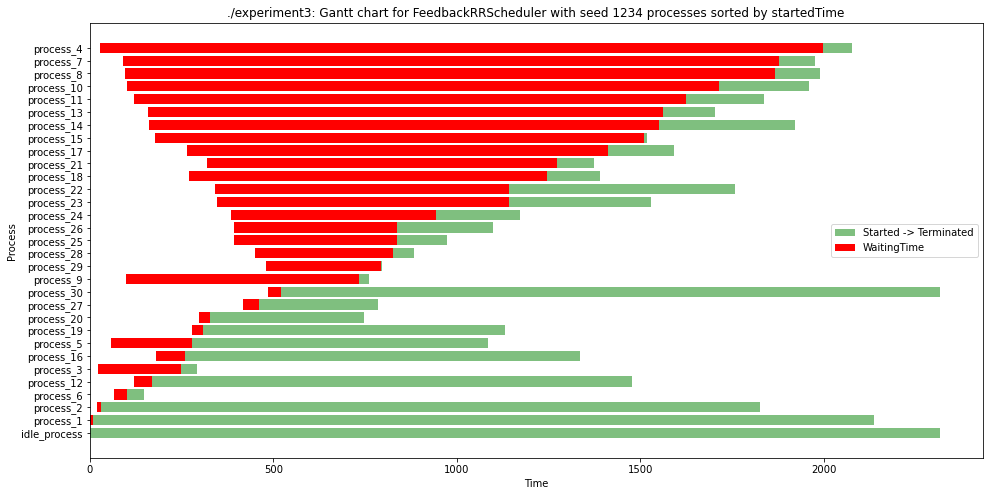

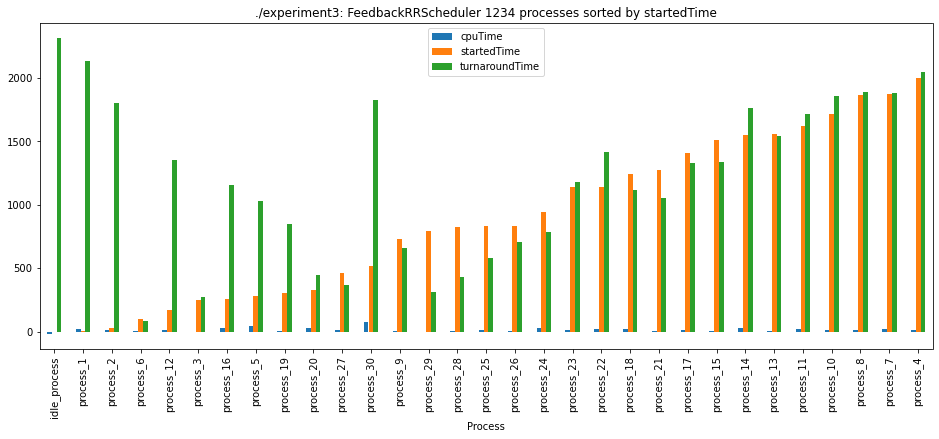

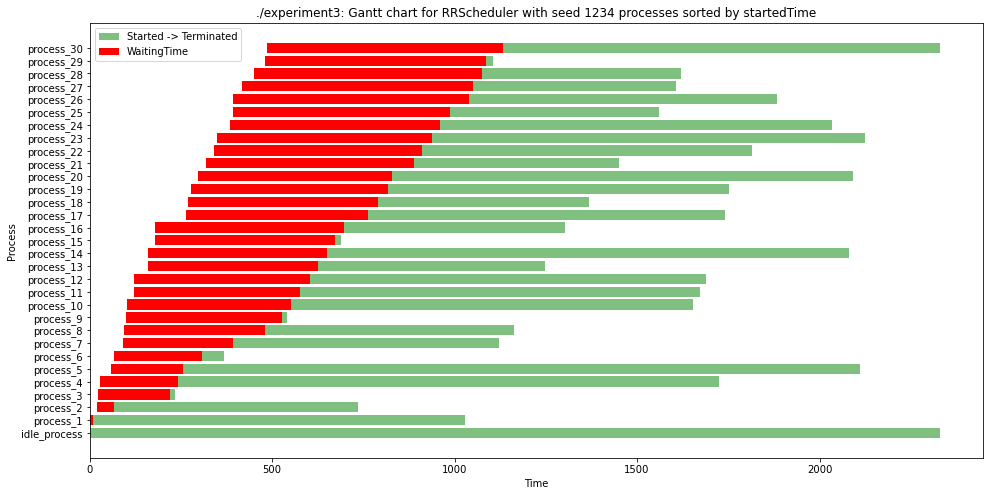

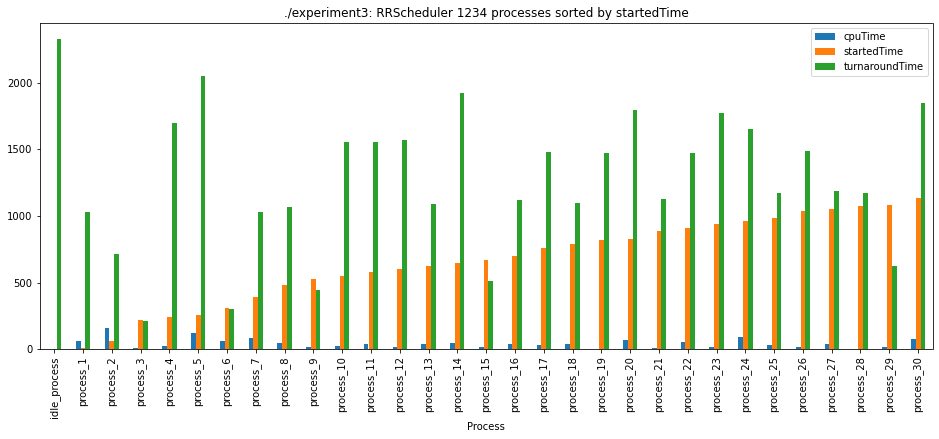

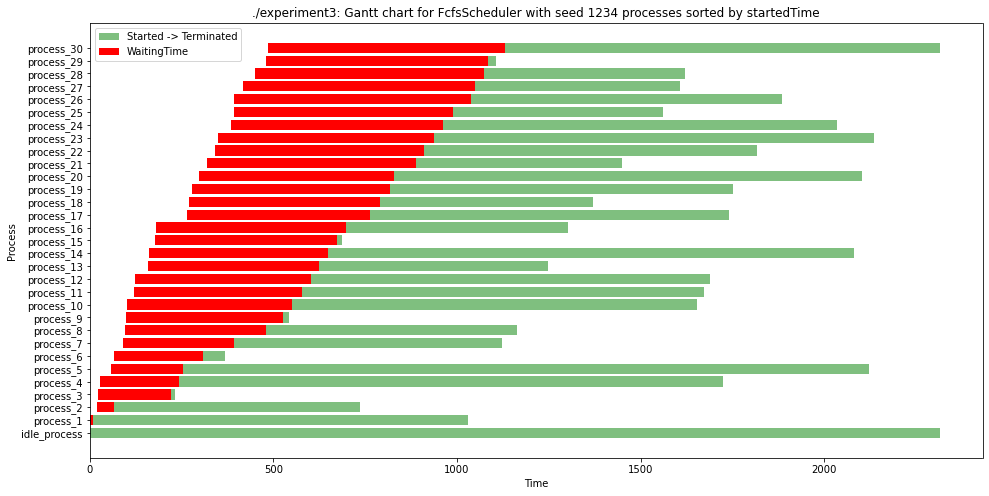

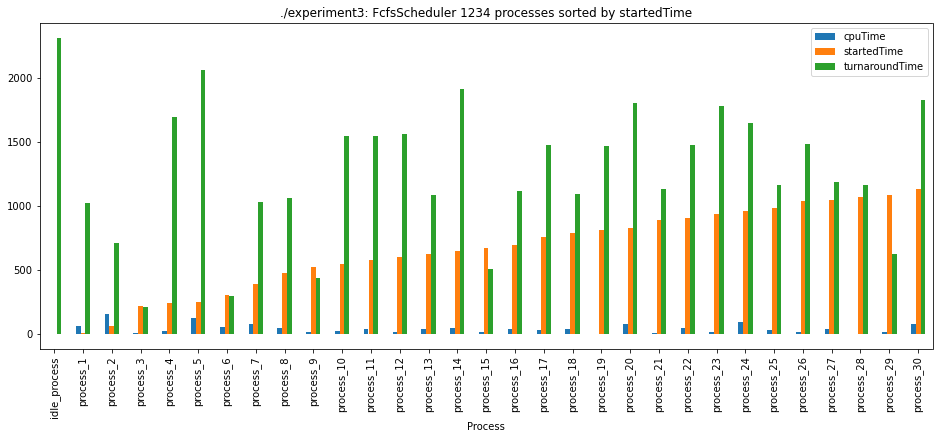

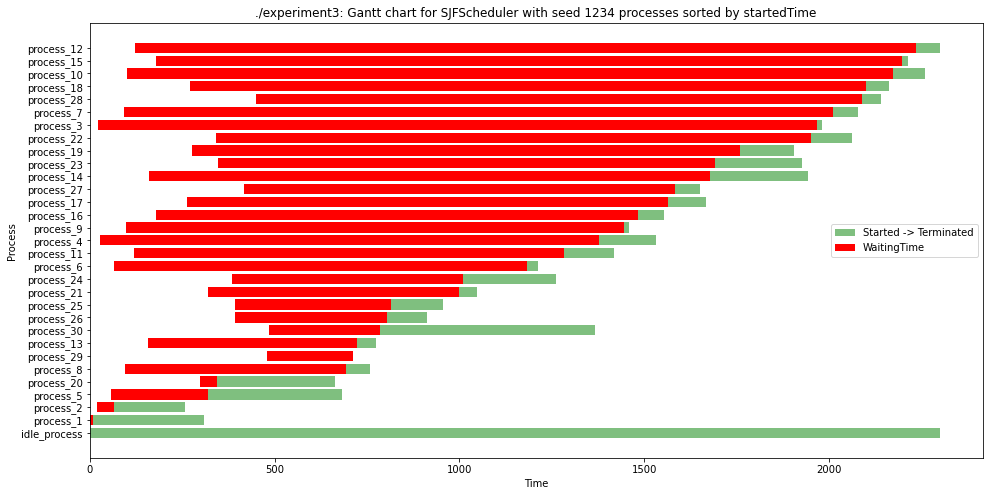

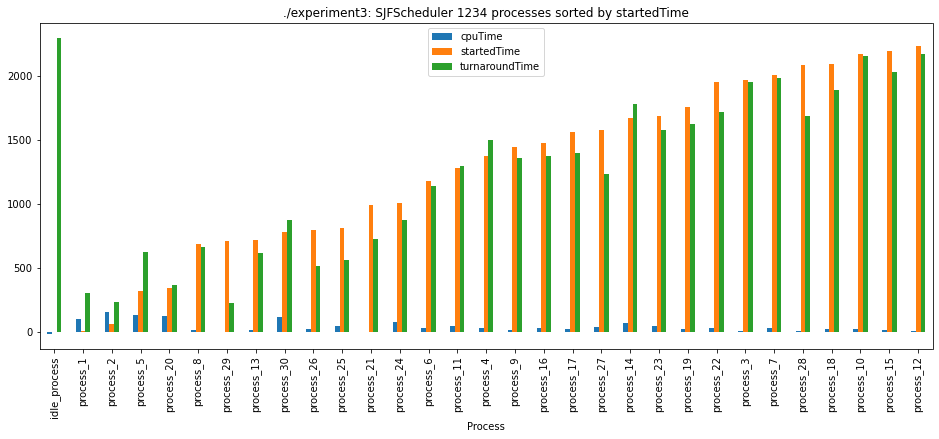

In [26]:
seed_to_analyse = '1234'
schedulers = ['FeedbackRRScheduler', 'RRScheduler', 'FcfsScheduler', 'SJFScheduler']
for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)

### Results for Seed 5124

CPU Utilization for FeedbackRRScheduler: 98.979%
CPU Utilization for RRScheduler: 98.989%
CPU Utilization for FcfsScheduler: 98.989%
CPU Utilization for SJFScheduler: 98.989%


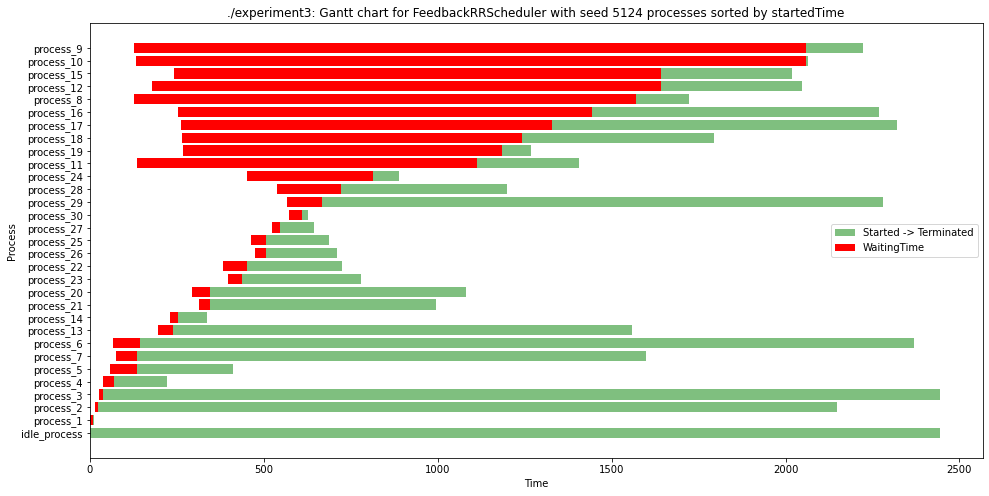

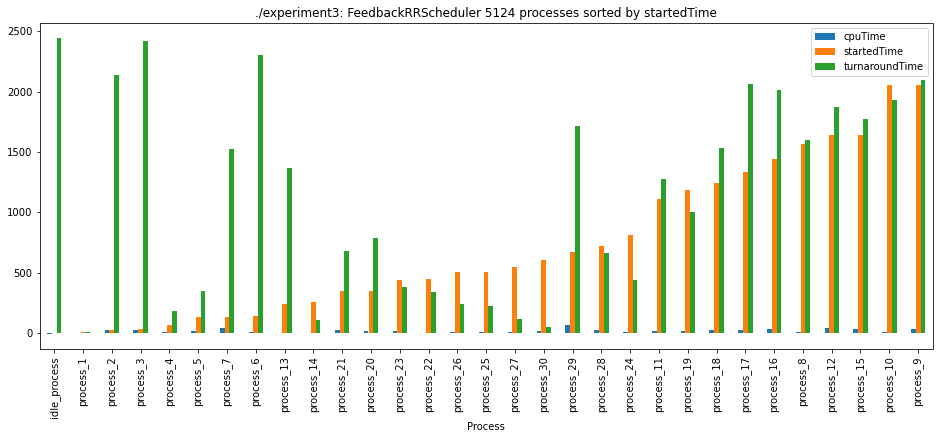

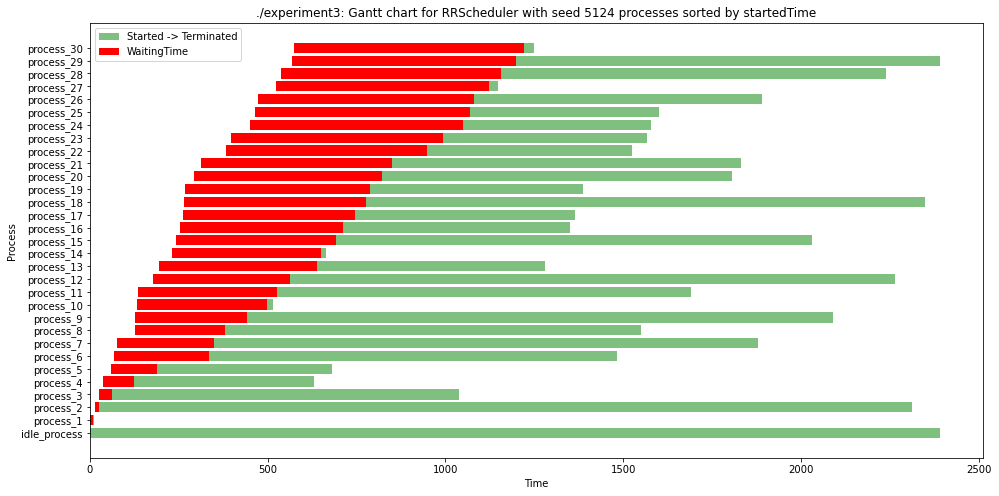

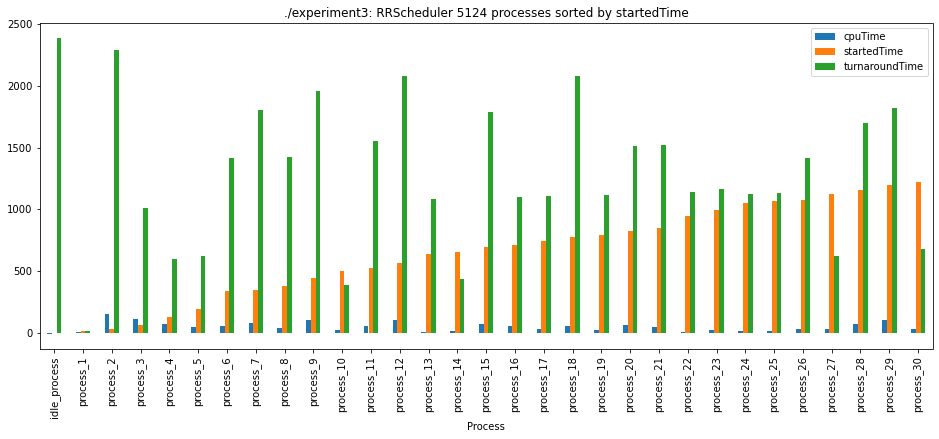

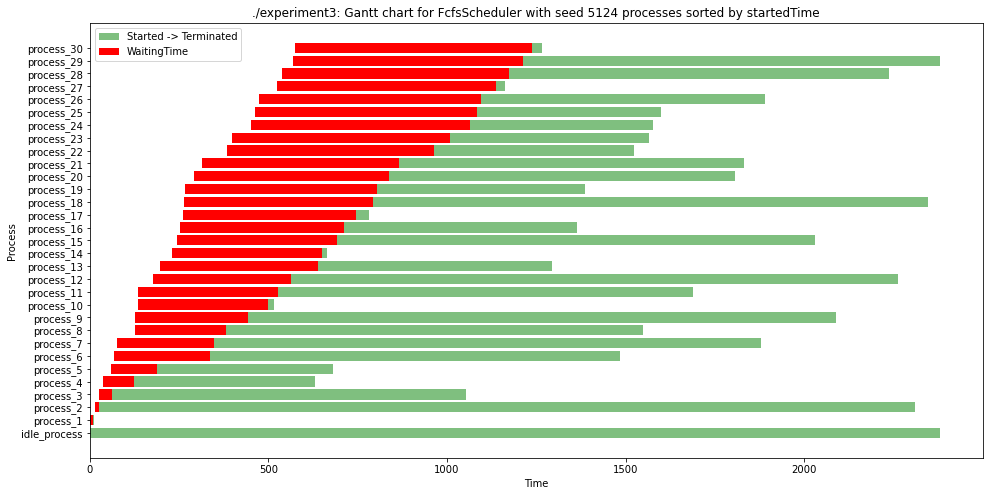

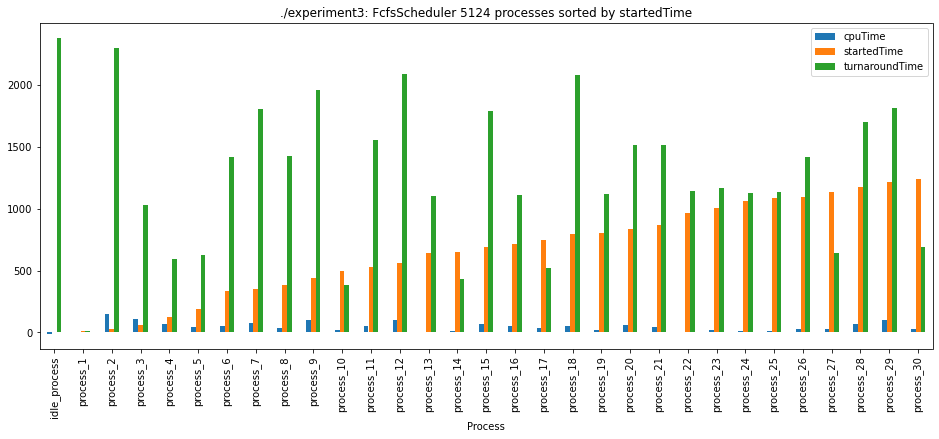

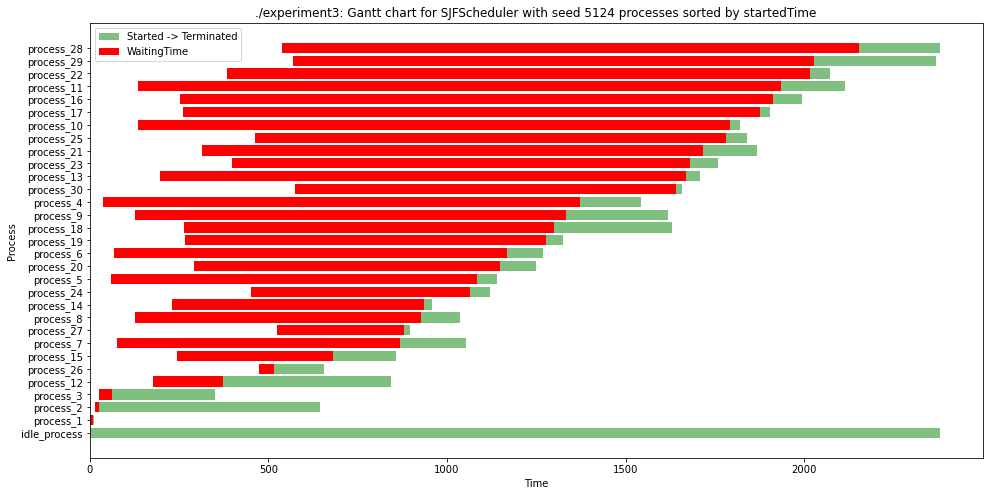

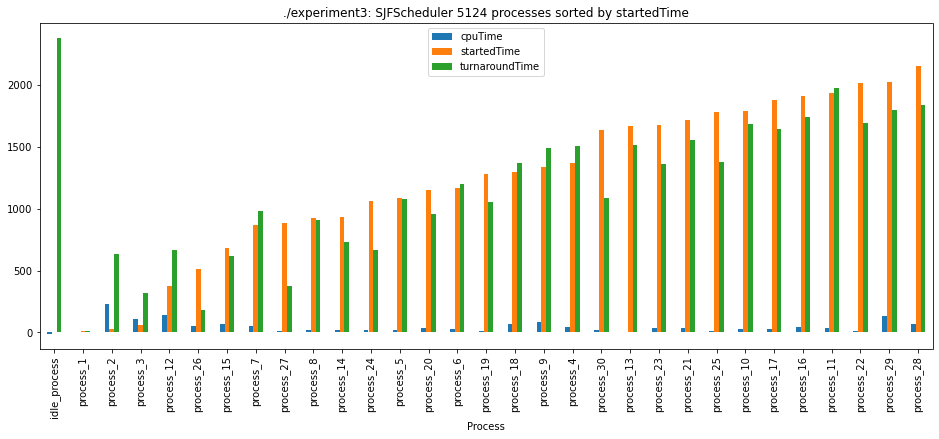

In [27]:
seed_to_analyse = '5124'
for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)

### Results for Seed 5678

CPU Utilization for FeedbackRRScheduler: 98.986%
CPU Utilization for RRScheduler: 98.994%
CPU Utilization for FcfsScheduler: 98.994%
CPU Utilization for SJFScheduler: 98.988%


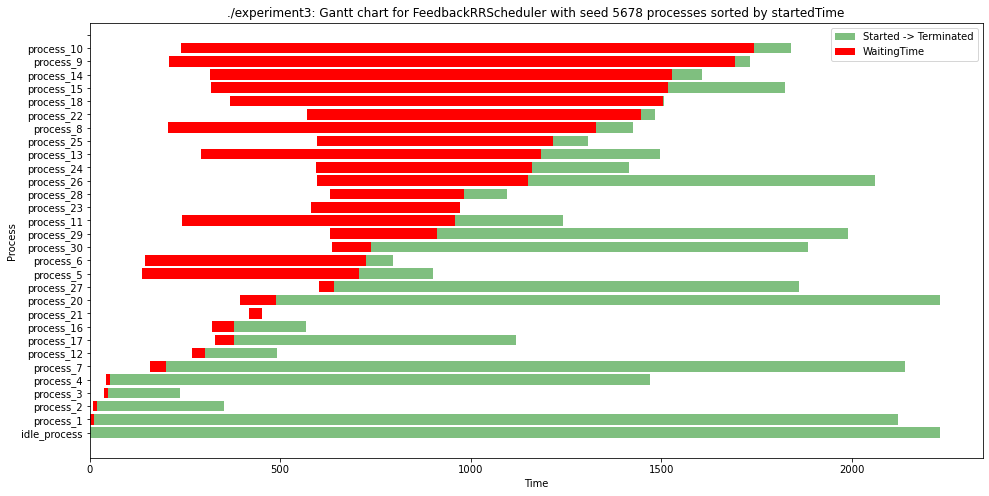

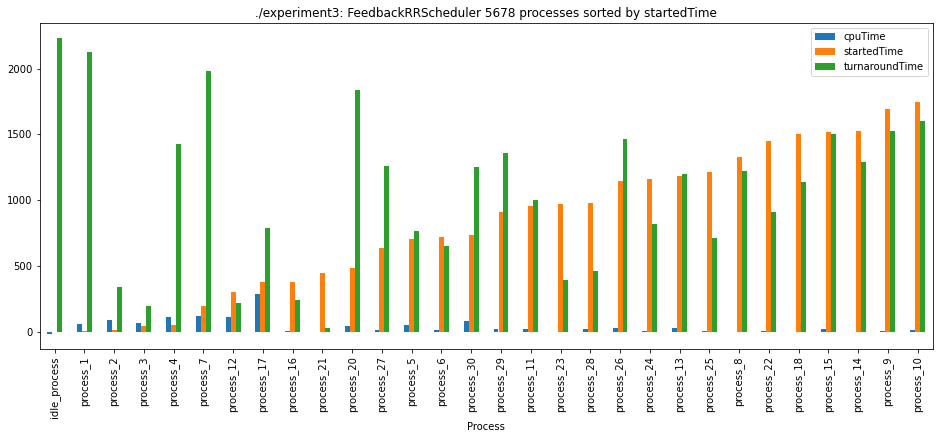

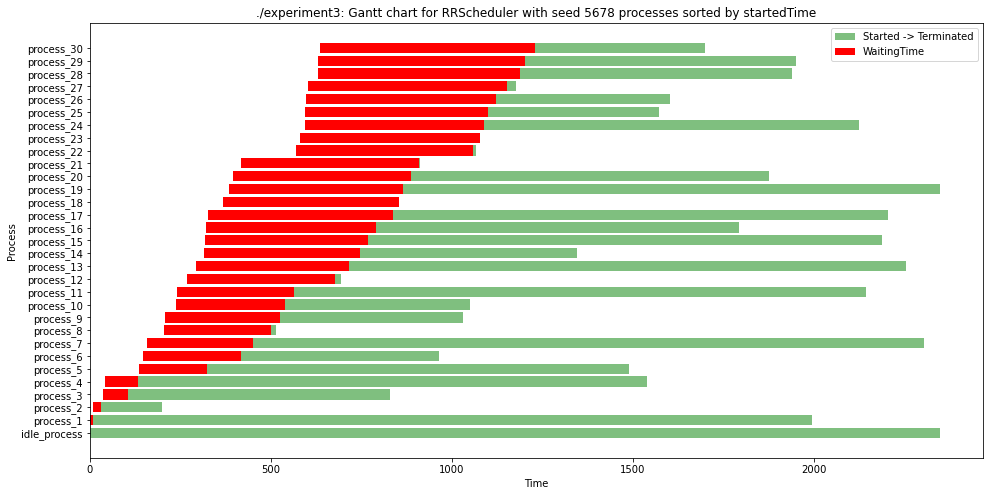

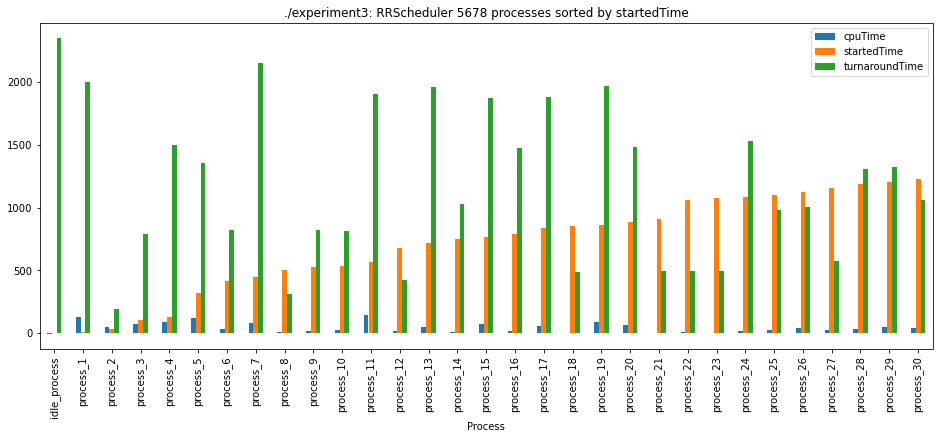

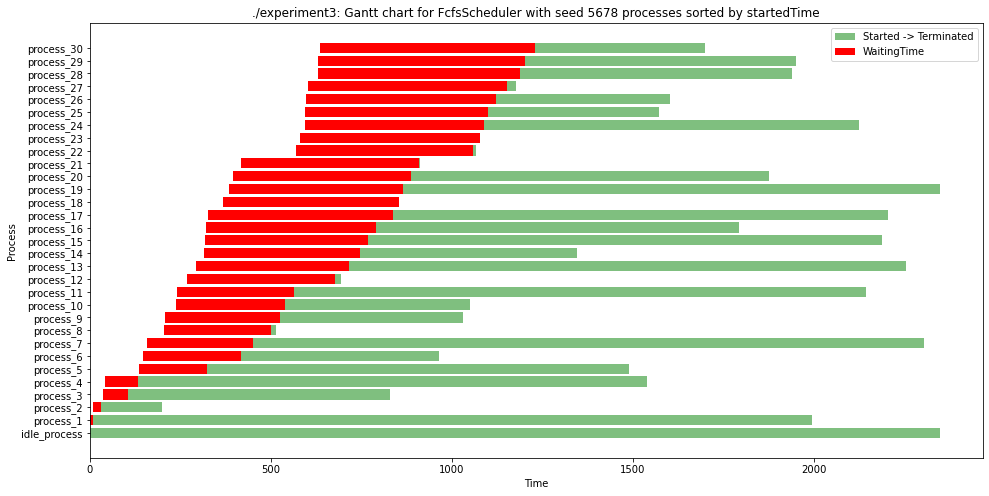

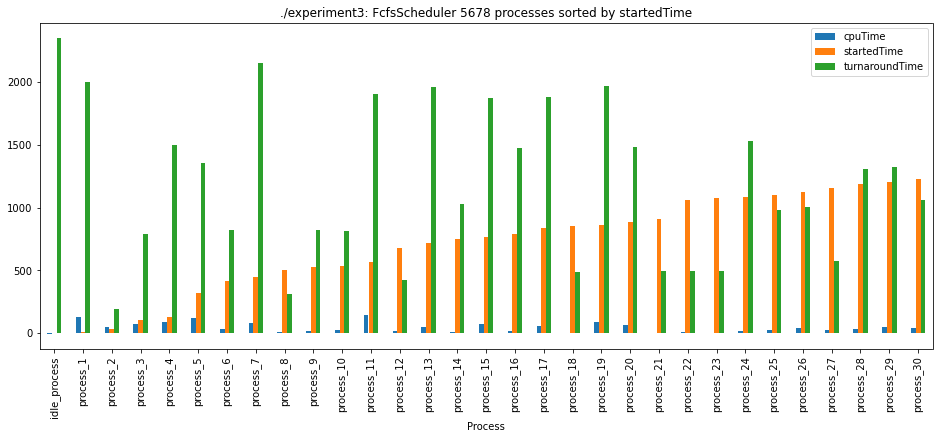

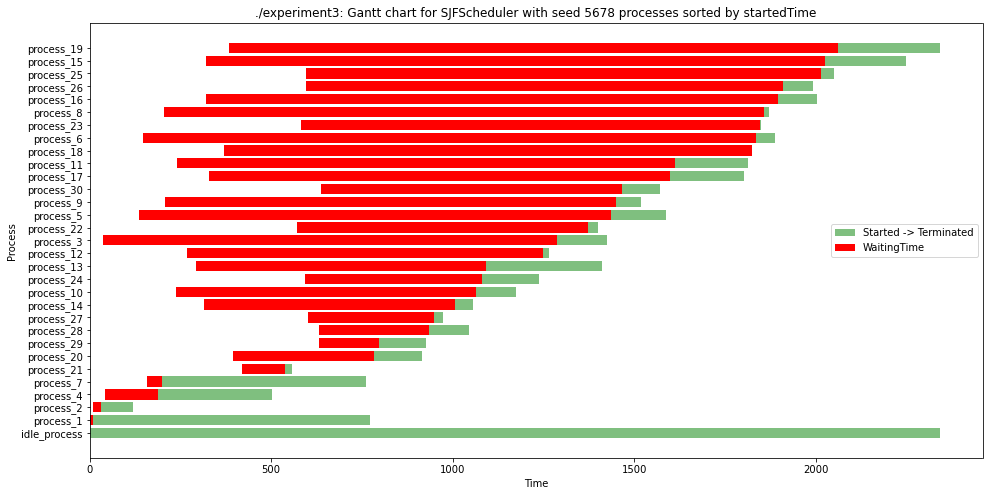

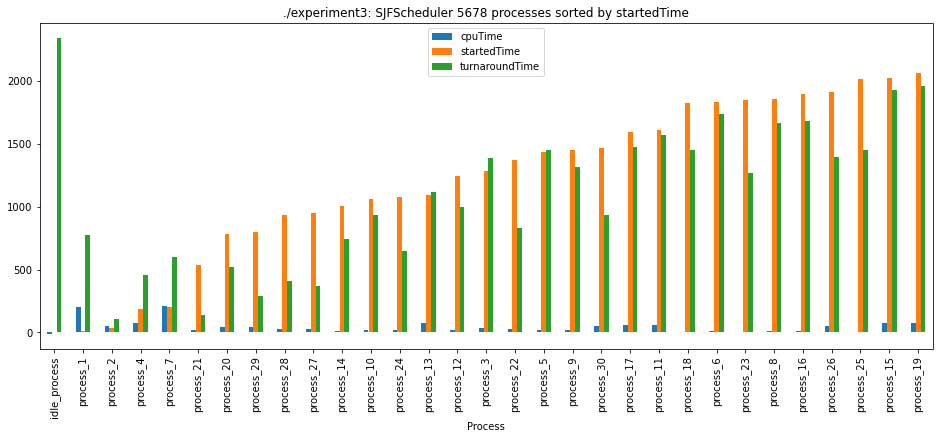

In [28]:
seed_to_analyse = '5678'
for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)

### Results for Seed 6789

CPU Utilization for FeedbackRRScheduler: 98.981%
CPU Utilization for RRScheduler: 98.993%
CPU Utilization for FcfsScheduler: 98.993%
CPU Utilization for SJFScheduler: 98.993%


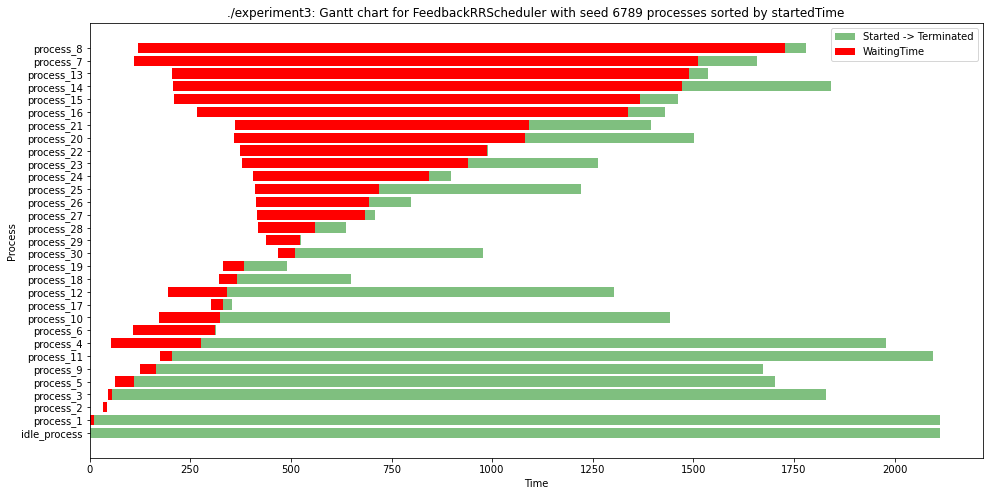

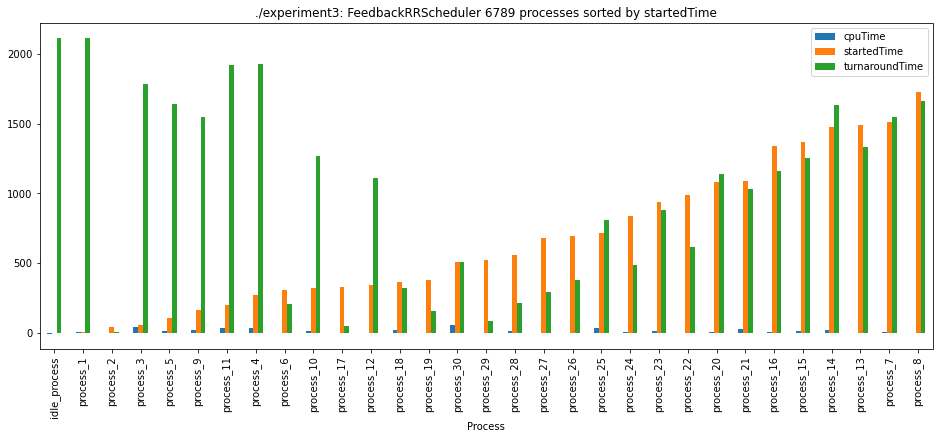

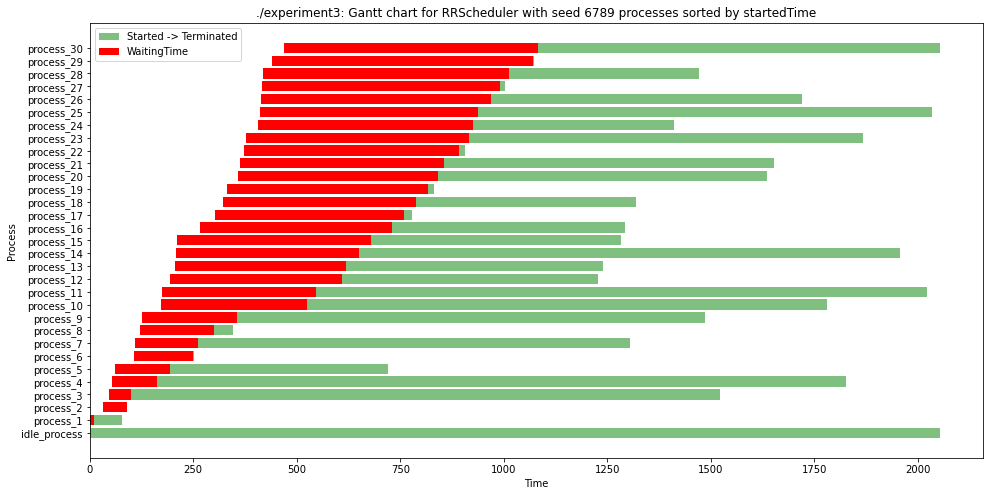

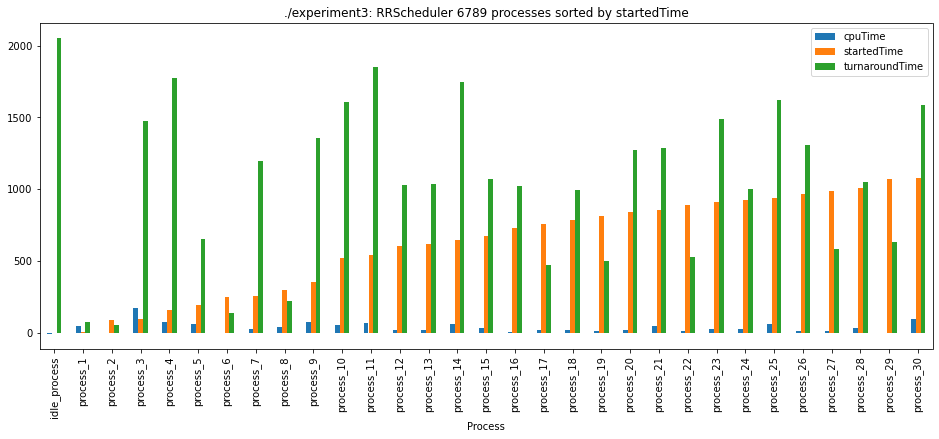

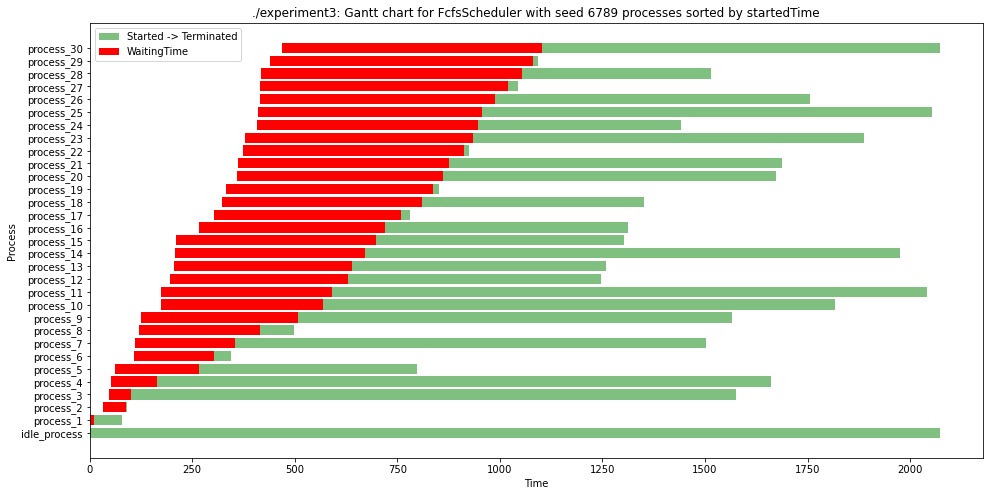

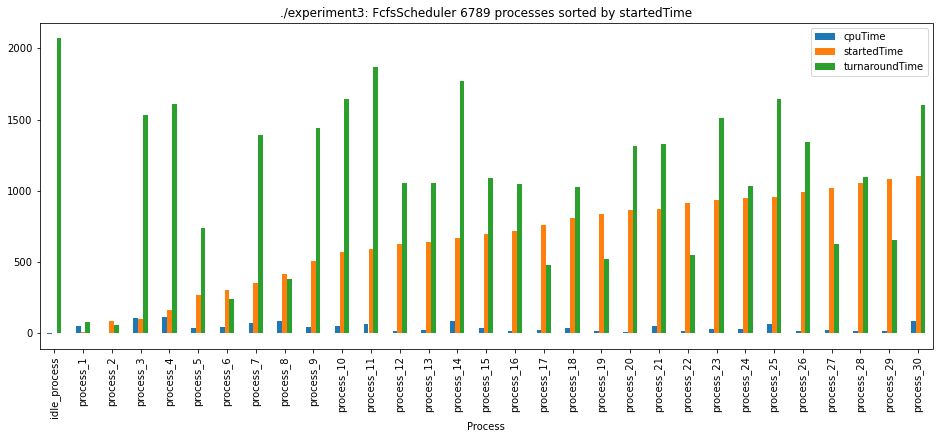

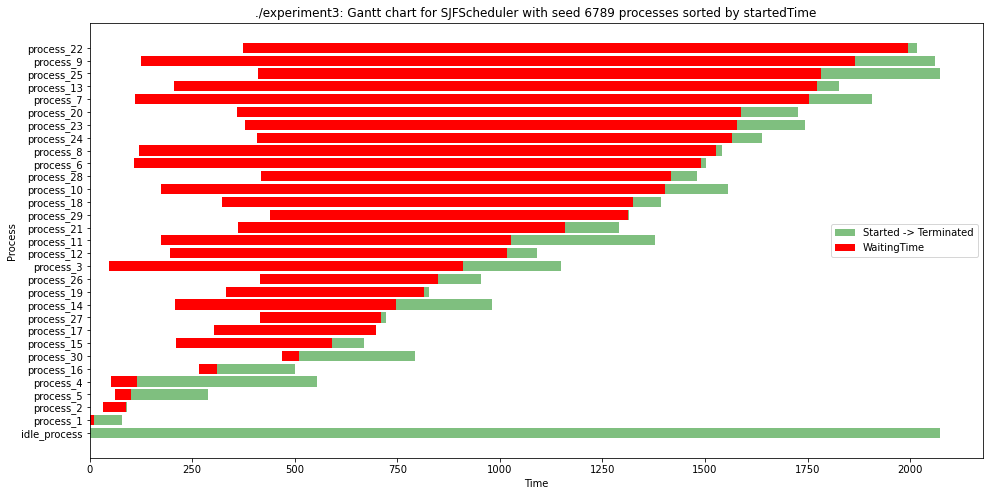

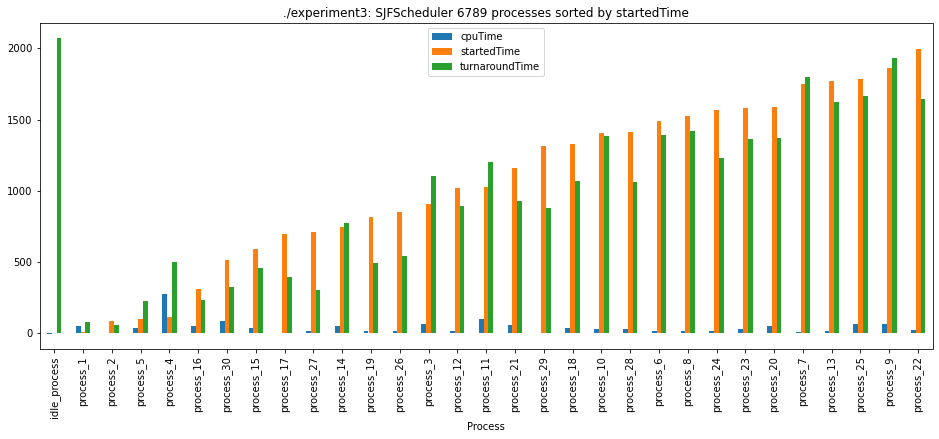

In [29]:
seed_to_analyse = '6789'
for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)

### Results for Seed 91011

CPU Utilization for FeedbackRRScheduler: 98.981%
CPU Utilization for RRScheduler: 98.993%
CPU Utilization for FcfsScheduler: 98.993%
CPU Utilization for SJFScheduler: 98.993%


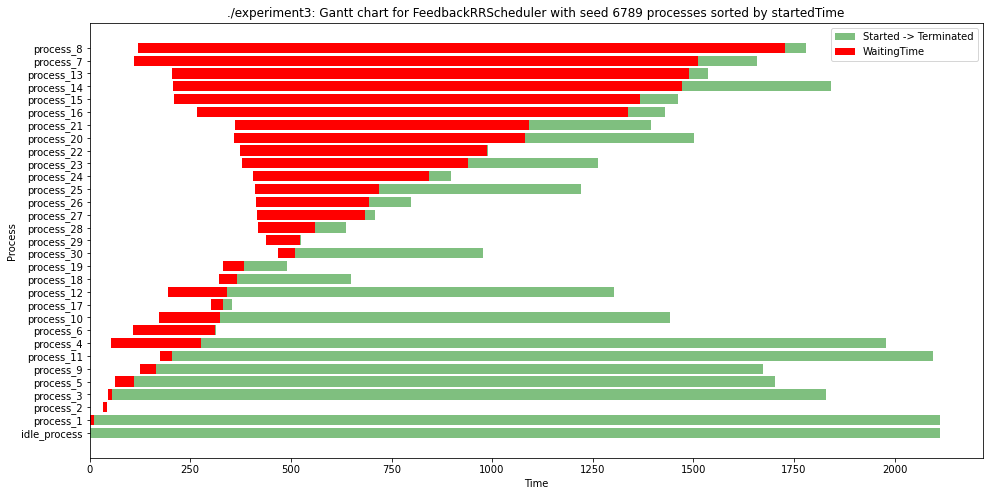

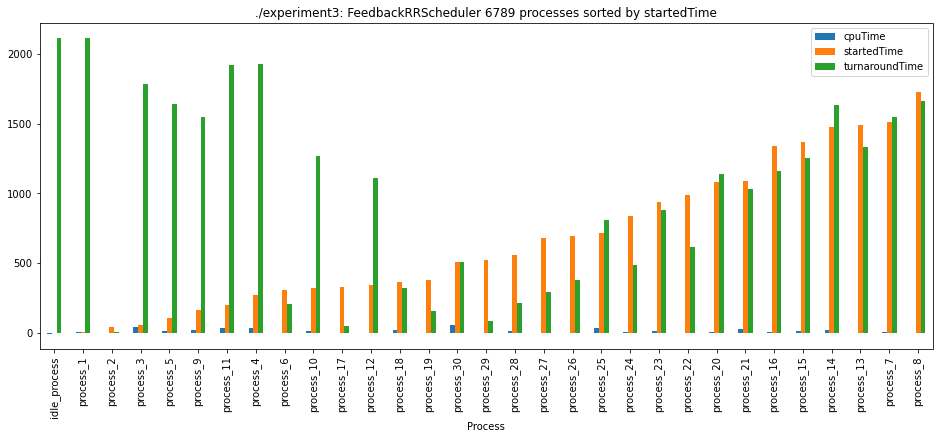

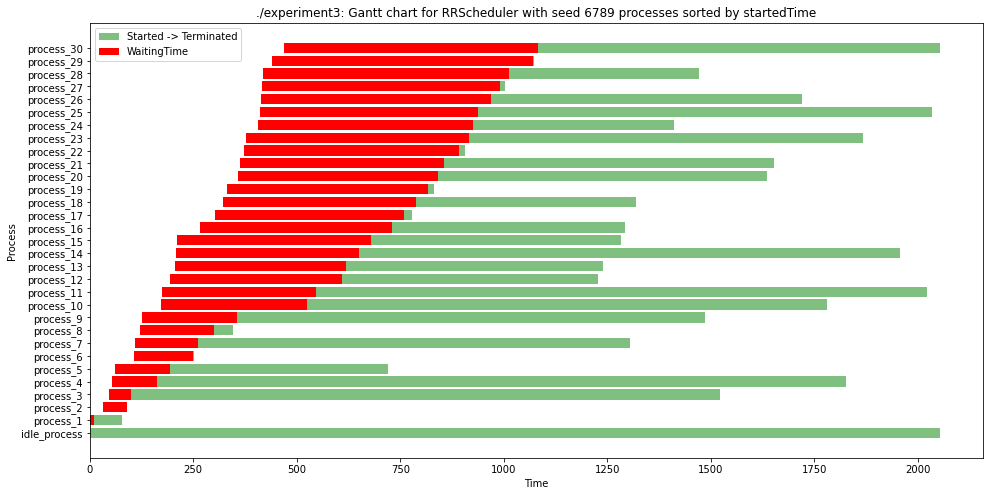

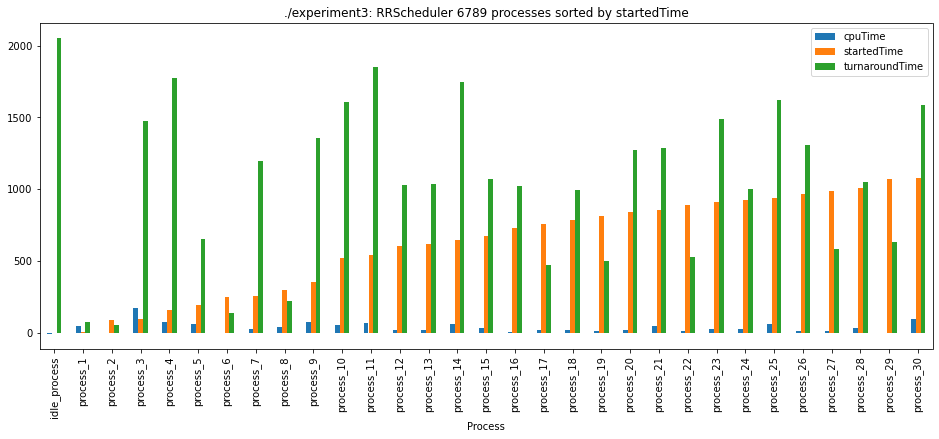

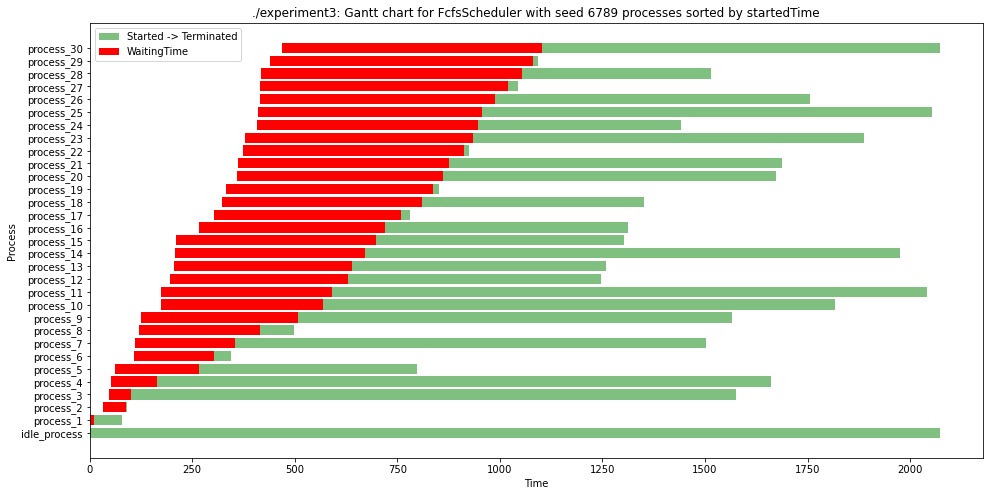

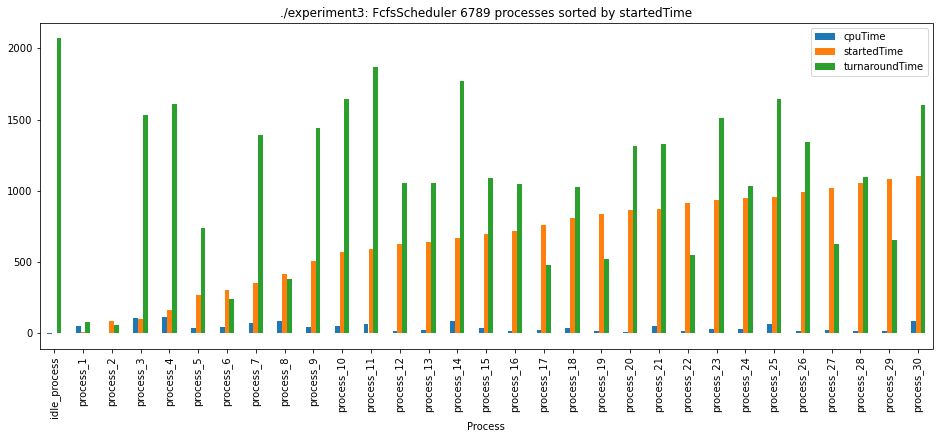

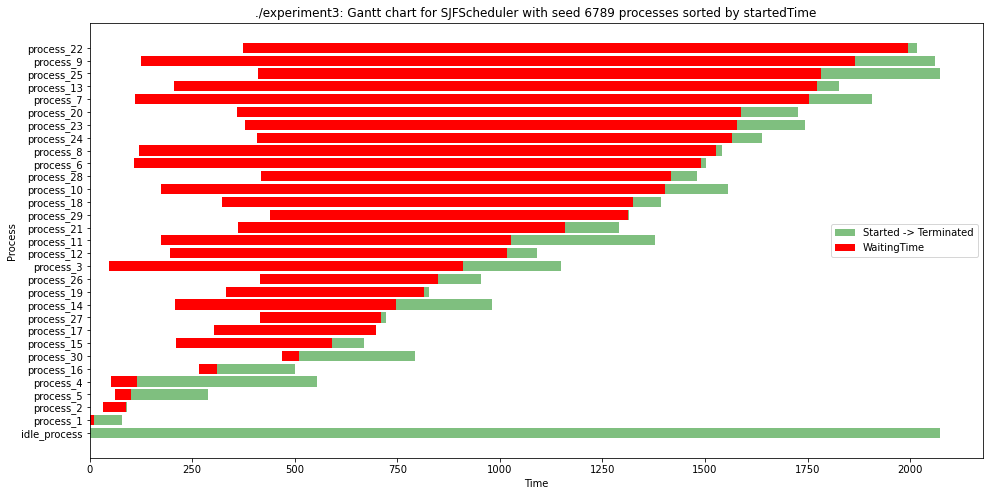

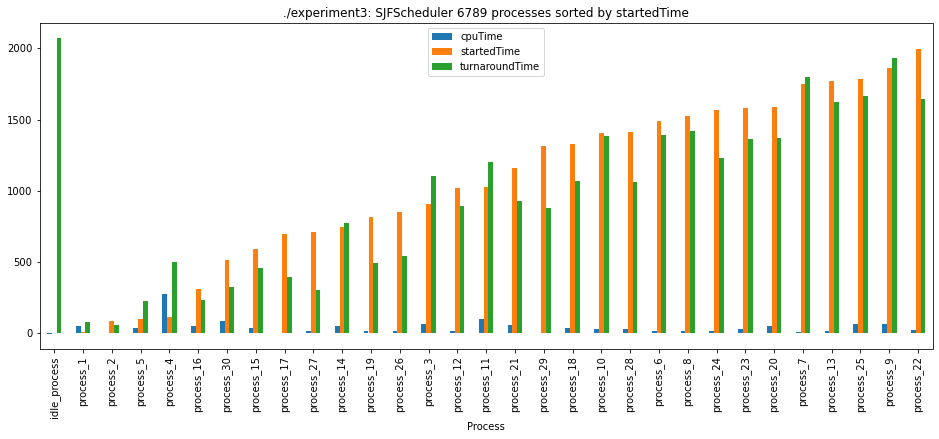

In [30]:
for scheduler in schedulers:
	show_results(exp, scheduler, seed_to_analyse)

### Analysis of Results
Upon examining the Gantt Charts for each of the results, it is clear that the Shortest Job First algorithm is suffering from the convoy effect to some extent, this will be due to the estimations performed by the algorithm, as it is unable to accurately estimate the burst times of the processes since there is so much variation. We will look to improve this.

First, we will compare the Waiting Times, Turnaround Times and CPU Utilisation for each of the algorithms over the 5 seeds.

In [78]:
means = results.groupby(['Scheduler']).mean()
stds = results.groupby(['Scheduler']).std()

stds = stds.rename(columns={
	'MeanWaitingTime': 'StdDevWaitingTime',
	'MeanTurnaroundTime': 'StdDevTurnaroundTime',
	'CpuUtilization': 'StdDevCpuUtilization',
	'MeanResponseTime': 'StdDevResponseTime'
})

print("Means of results for each scheduler over all seeds")
means


Means of results for each scheduler over all seeds


,Seed,MeanWaitingTime,MeanTurnaroundTime,MeanResponseTime,CpuUtilization
Scheduler,,,,,
FcfsScheduler,2.469025e+18,405.593548,1184.083871,402.761290,98.993347
FeedbackRRScheduler,2.469025e+18,496.897849,1086.497204,494.099355,98.977177
ImprovedSJFScheduler,3.416082e+61,737.735484,1086.070968,734.877419,98.992698
NewSJFScheduler,1.024825e+20,737.735484,1086.070968,734.877419,98.992698
RRScheduler,2.469025e+18,392.200000,1173.858065,389.367742,98.994001
SJFScheduler,2.469025e+18,894.367742,1097.122581,891.535484,98.990124


In [79]:
print("Standard Deviations of results for each scheduler over all seeds")
stds


Standard Deviations of results for each scheduler over all seeds


,Seed,StdDevWaitingTime,StdDevTurnaroundTime,StdDevResponseTime,StdDevCpuUtilization
Scheduler,,,,,
FcfsScheduler,2290.385273,21.901071,93.117089,21.949813,0.003414
FeedbackRRScheduler,2290.385273,106.481280,86.921470,106.487970,0.010333
ImprovedSJFScheduler,35786.034024,161.984403,125.589740,161.957240,0.004438
NewSJFScheduler,38653.334522,174.963153,135.652423,174.933813,0.004793
RRScheduler,2290.385273,28.646954,114.684487,28.657878,0.004939
SJFScheduler,2290.385273,109.270958,119.248487,109.258664,0.002500


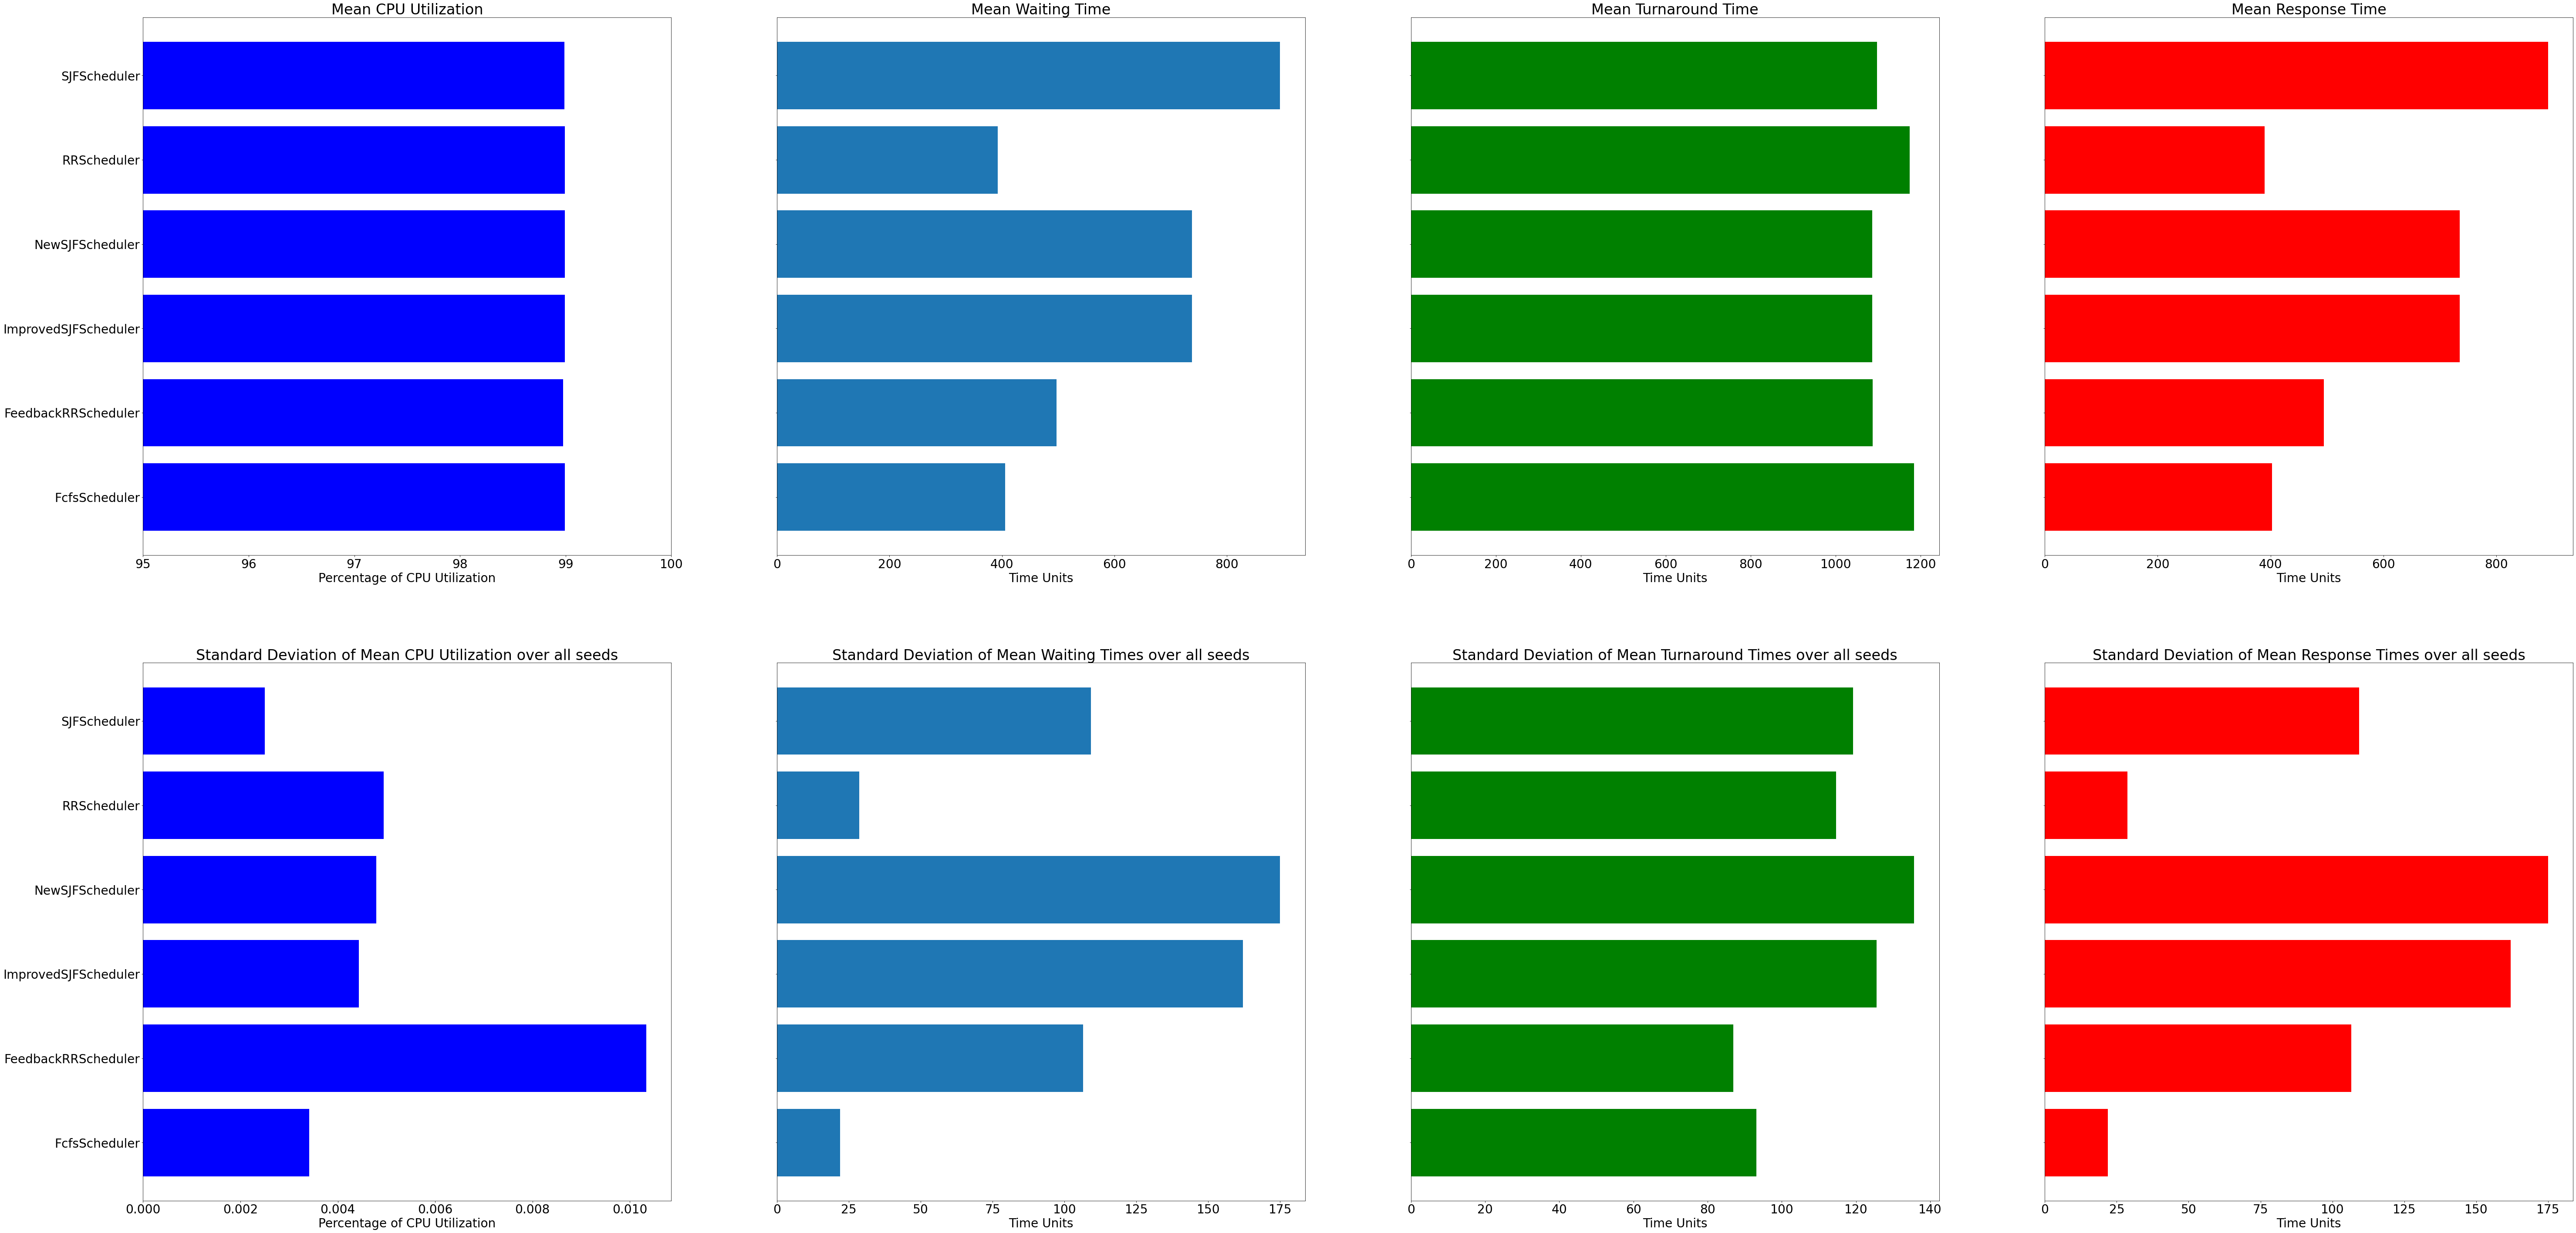

In [80]:
def plot_means_and_std(means, stds):
	fig, (ax1, ax2) = plt.subplots(2,4, sharey='all',)
	fig.set_size_inches(100, 50)


	ax1[0].set_xlabel("Percentage of CPU Utilization")
	ax1[0].barh(means.index, means['CpuUtilization'], color='b')
	ax1[0].set_title("Mean CPU Utilization")
	ax1[0].set_xbound(95, 100)

	ax1[1].set_xlabel("Time Units")
	ax1[1].set_title("Mean Waiting Time")
	ax1[1].barh(means.index, means['MeanWaitingTime'])

	ax1[2].set_title("Mean Turnaround Time")
	ax1[2].barh(means.index, means['MeanTurnaroundTime'], color='g')
	ax1[2].set_xlabel("Time Units")

	ax1[3].set_title("Mean Response Time")
	ax1[3].barh(means.index, means['MeanResponseTime'], color='r')
	ax1[3].set_xlabel("Time Units")

	ax2[0].set_xlabel("Percentage of CPU Utilization")
	ax2[0].barh(means.index, stds['StdDevCpuUtilization'], color='b')
	ax2[0].set_title("Standard Deviation of Mean CPU Utilization over all seeds")

	ax2[1].set_xlabel("Time Units")
	ax2[1].set_title("Standard Deviation of Mean Waiting Times over all seeds")
	ax2[1].barh(means.index, stds['StdDevWaitingTime'])

	ax2[2].set_title("Standard Deviation of Mean Turnaround Times over all seeds")
	ax2[2].barh(means.index, stds['StdDevTurnaroundTime'], color='g')
	ax2[2].set_xlabel("Time Units")

	ax2[3].set_title("Standard Deviation of Mean Response Times over all seeds")
	ax2[3].barh(means.index, stds['StdDevResponseTime'], color='r')
	ax2[3].set_xlabel("Time Units")
plot_means_and_std(means, stds)

The above figure shows the means and standard deviations for the CPU Utilisation, Waiting Times and Turnaround Times and Response Times for each of the algorithms over the 5 seeds. 

As can be seen above, the Shortest Job First algorithm has the highest average response time and wait time. However, we can also the that the standard deviation on all of these statistics for the Shortest Job First algorithm is very high, which is likely due to the algorithm not being able to accurately estimate the burst times of the processes using the exponential averaging method given the initial parameters it was given.

Above, we can see that the Feedback Round Robin scheduler performs poorly as far as waiting times and turnaround times. This can be seen in the Gantt chart and likely comes from the large number of processes and the large difference in CPU and IO burst times, which is causing the algorithm to demote processes after they have reached their time quantum, which is small in comparison to the average IO burst time.

## Improving the Estimation of Burst Times for the Shortest Job First Algorithm for Highly Varying Workloads

To better predict the estimation of burst times in the non-preemptive shortest job first algorithm, we will look at how the estimation of the next burst time is actually calculated.

We define the initial burst time and alpha burst time as the following.

$$\text{Initial Burst Time - }\tau_0$$
$$\text{Alpha Burst Time - }\alpha $$

Now, using these values. We can calculate $\tau_1 $ by the following equation.
$$ \tau_1 = (\alpha \cdot \tau_0) \cdot (1 - \alpha) \tau_0 $$

More generally, we calculate the next burst time by iterating to calculate $\tau_n $ for the $n\text{th}$ burst.

$$ \tau_n = (\alpha \cdot \tau_{n-1}) \cdot (1 - \alpha) \tau_{n-1} $$

Note that after the first burst, we no longer need to use the initial burst time, as we can use the previous burst time to estimate.

We can note that this equation shows us that the $\alpha$ burst time is key to estimation as it signifies (between 0 and 1) how much the burst time is influenced by the previous burst time. In highly varied scenarios, this should be a low value, as the previous burst time will given little indication of the next burst time. Initially for this experiment, we set the $\alpha$ burst time to 0.7, which is quite high, we should make this value lower to improve the estimation of the burst times.

In addition, our initial burst time was set to 30, which is also quite high given that the average CPU burst time is 5 and the average IO burst time is 25. We should make this value the average of these two values which is 15. However, in a real world scenario, we would likely not know what the average CPU/IO burst times are, so we would need to look closer at the workload to determine a good estimation technique.

In [34]:
exp3_improved = Experiment('../experiment4')
exp3_improved.sim_params[0].drop(['scheduler'])

,value
param,
timeLimit,5000
interruptTime,10
timeQuantum,20
initialBurstEstimate,15
alphaBurstEstimate,0.4
periodic,false


### Results for Updated Estimation of Burst Times

In [40]:
new_sjf_results = new_results()
for i, seed in enumerate(exp3_improved.all_seeds()):
	df = exp3_improved.get_output_for_seed('SJFScheduler', seed)
	cpu_util = exp3_improved.calculate_cpu_utilization_for_output('SJFScheduler', seed)
	waiting_time = df.waitingTime.mean()
	turnaround_time = df.turnaroundTime.mean()
	response_time = df.responseTime.mean()

	res = pd.DataFrame({
		'Scheduler': 'NewSJFScheduler',
		'Seed': seed,
		
		'CpuUtilization': cpu_util,
		'MeanWaitingTime': waiting_time,
		'MeanTurnaroundTime': turnaround_time,
		'MeanResponseTime': response_time
	}, index=[i]);

	new_sjf_results = pd.concat([new_sjf_results, res])



results = pd.concat([results, new_sjf_results], ignore_index=True)
new_sjf_results

,Seed,Scheduler,MeanWaitingTime,MeanTurnaroundTime,MeanResponseTime,CpuUtilization
0,5124,NewSJFScheduler,965.709677,1252.387097,962.806452,98.991573
1,1234,NewSJFScheduler,821.322581,1161.709677,818.548387,98.998524
2,5678,NewSJFScheduler,723.677419,1074.129032,720.741935,98.993612
3,6789,NewSJFScheduler,491.419355,888.516129,488.645161,98.985413
4,91011,NewSJFScheduler,686.548387,1053.612903,683.645161,98.994366


We will now analyse the results of the updated estimation and compare them to the results of the original estimation.

In [51]:
compared_sjfs = pd.concat([results[
	results['Scheduler'] == 'SJFScheduler'],
 new_sjf_results], ignore_index=True)
compared_sjfs.set_index('Seed', inplace=True)
compared_sjfs

,Scheduler,MeanWaitingTime,MeanTurnaroundTime,MeanResponseTime,CpuUtilization
Seed,,,,,
1234,SJFScheduler,1048.354839,1253.064516,1045.580645,98.987681
5124,SJFScheduler,956.290323,1173.774194,953.387097,98.988966
5678,SJFScheduler,878.225806,1095.548387,875.290323,98.988338
6789,SJFScheduler,794.483871,981.612903,791.709677,98.992817
6789,SJFScheduler,794.483871,981.612903,791.709677,98.992817
5124,NewSJFScheduler,965.709677,1252.387097,962.806452,98.991573
1234,NewSJFScheduler,821.322581,1161.709677,818.548387,98.998524
5678,NewSJFScheduler,723.677419,1074.129032,720.741935,98.993612
6789,NewSJFScheduler,491.419355,888.516129,488.645161,98.985413


In [81]:
means = compared_sjfs.groupby(['Scheduler']).mean()
stds = compared_sjfs.groupby(['Scheduler']).std()

stds = stds.rename(columns={
	'MeanWaitingTime': 'StdDevWaitingTime',
	'MeanTurnaroundTime': 'StdDevTurnaroundTime',
	'CpuUtilization': 'StdDevCpuUtilization',
	'MeanResponseTime': 'StdDevResponseTime'
})


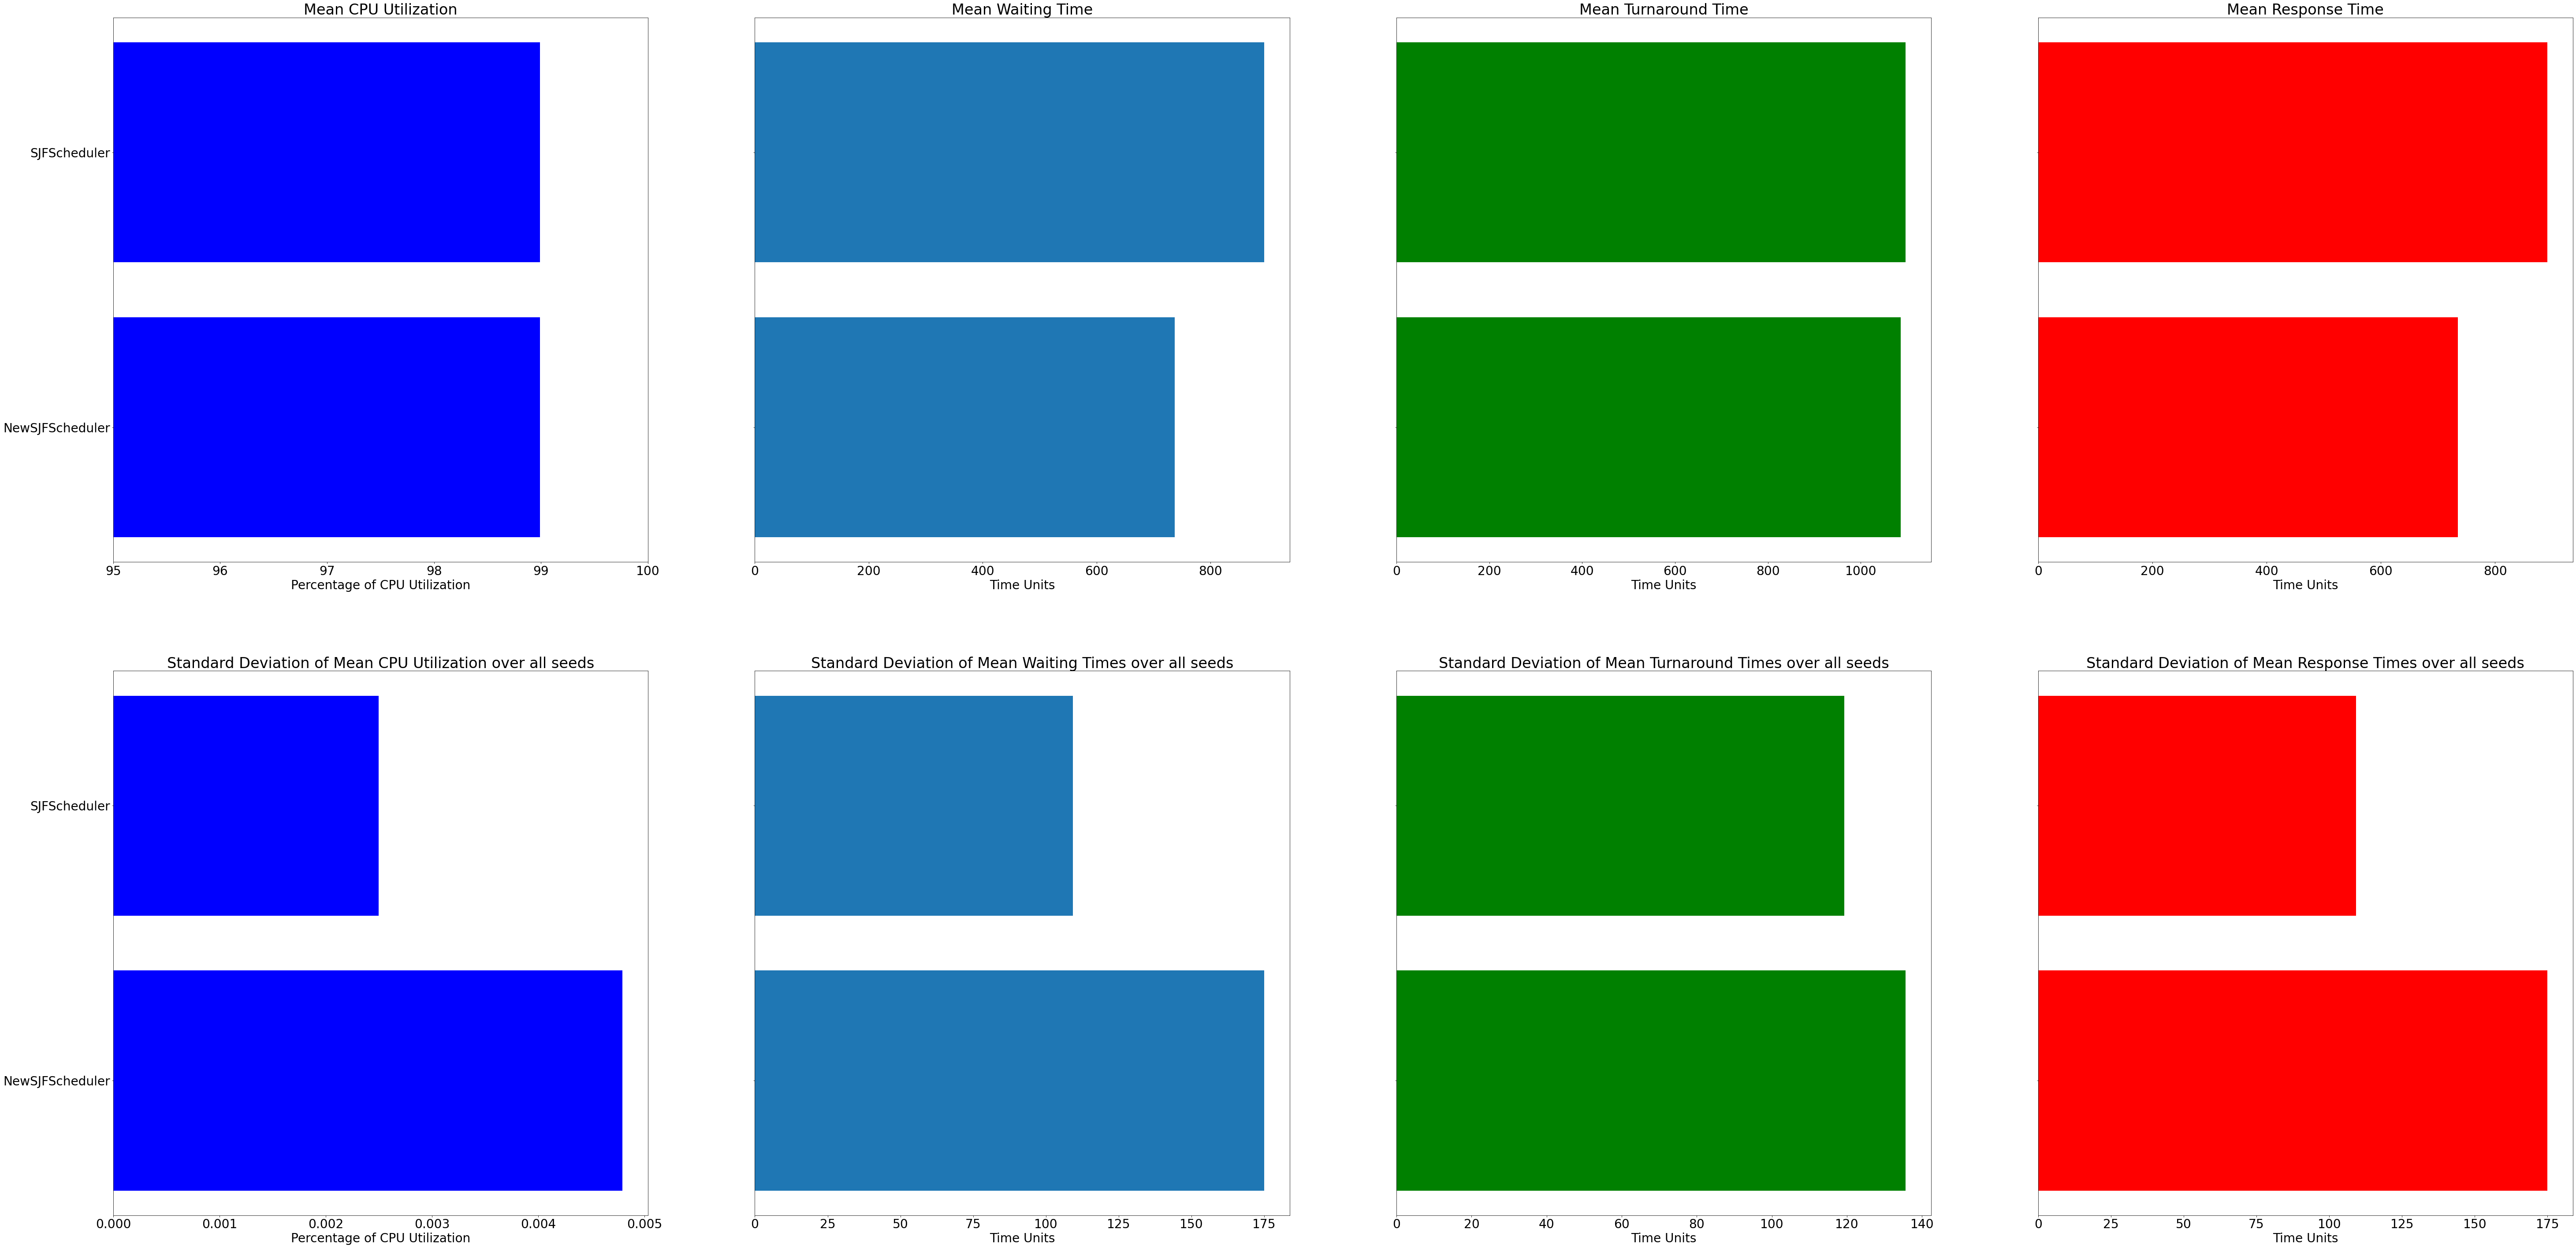

In [77]:
plot_means_and_std(means, stds)

As can be seen in the above graphs, the New Shortest Job First Scheduler with updated parameters on average performs far better than the original Shortest Job First Scheduler. Since we updated the parameters, we can see that the average waiting time is much lower, as is the mean wait time and mean response time. Turnaround time and CPU Utilisation are seemingly unaffected by the updated parameters. 

It is notable that the Standard Deviations for the New Shortest Job First Scheduler are much higher than the original Shortest Job First Scheduler. Since the `alphaBurstEstimate` is much lower than it was previously, this means the scheduler expects more variation in the burst times, so a higher standard deviation is expected for the metrics we have collected. 

## Conclusion

In this experiment I have analysed the performance of each of the algorithms when dealing with highly varying workloads. I have discovered that the Round Robin scheduler is generally the best scheduling algorithm for this scenario if minimising response times is key. However, the First-Come-First-Serve algorithm performs well when it comes to minimizing wait time as well as response time, so in a scenario where predicting burst times is not an option, the First-Come-First-Serve algorithm is the best choice.

In addition, I have examined the impacts of changing the parameters for the non-preemptive Shortest Job First scheduler and have seen how we can reduce the `alphaBurstTime` to improve the estimation of burst times when processes vary significantly in their CPU and IO burst times. This experiment has shown me that the Shortest Job First algorithm can certainly be improved to deal with unpredictable workloads and can also handle well workloads where the burst times are similar. However, finding the correct parameters for `initialBurstTime` and `alphaBurstTime` to ensure the best performance is a particularly difficult task, I would be interested to see any machine learning approaches that exist to tune these parameters for specific workloads.

